### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (2 балл)

4) Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями (1 балл)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [159]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 2
config.num_epochs = 25
config.noise_size = 100
config.print_freq = 100
config.n_critic = 5  
config.clip_value = 0.01  
config.lr = 0.00005  

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|███████████████████████████████████████| 26.4M/26.4M [00:52<00:00, 502kB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 445kB/s]
100%|███████████████████████████████████████| 4.42M/4.42M [00:10<00:00, 417kB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 3.92MB/s]


In [160]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [161]:
len(dataloader)

938

In [162]:
for image, cat in dataloader:
    break

In [163]:
image.size()

torch.Size([64, 1, 28, 28])

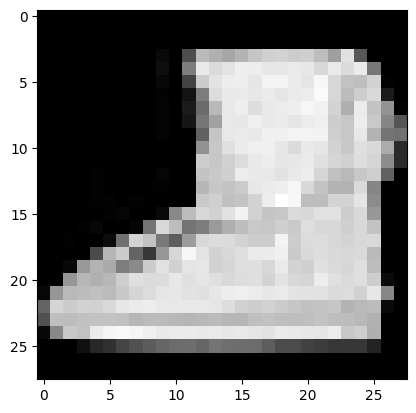

In [25]:
plt.imshow(image[4].squeeze(), cmap='gray')
plt.show()

### 1. Wasserstein GAN

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 28*28),
            nn.Tanh()  
        )
        
    def forward(self, x):
        return self.model(x)

In [14]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [15]:
generator = Generator()
critic = Critic()

In [16]:
optim_G = optim.RMSprop(generator.parameters(), lr=config.lr)
optim_C = optim.RMSprop(critic.parameters(), lr=config.lr)

In [17]:
fixed_noise = torch.FloatTensor(64, config.noise_size).normal_(0, 1)

In [18]:
def clip_weights(model, clip_value):
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)

[Epoch 1/25] [Batch 100/938] [C loss: -0.1267] [G loss: -2.0773]
[Epoch 1/25] [Batch 200/938] [C loss: -0.5922] [G loss: 0.2396]
[Epoch 1/25] [Batch 300/938] [C loss: -0.4318] [G loss: -0.0776]
[Epoch 1/25] [Batch 400/938] [C loss: -0.5419] [G loss: -0.4071]
[Epoch 1/25] [Batch 500/938] [C loss: -0.6483] [G loss: -0.5697]
[Epoch 1/25] [Batch 600/938] [C loss: -0.5816] [G loss: -0.8356]
[Epoch 1/25] [Batch 700/938] [C loss: -0.6032] [G loss: -0.3311]
[Epoch 1/25] [Batch 800/938] [C loss: -0.3677] [G loss: -1.0401]
[Epoch 1/25] [Batch 900/938] [C loss: -0.6094] [G loss: -0.0951]
[Epoch 2/25] [Batch 100/938] [C loss: -0.3644] [G loss: -0.5098]
[Epoch 2/25] [Batch 200/938] [C loss: -0.5128] [G loss: -0.5933]
[Epoch 2/25] [Batch 300/938] [C loss: -0.5105] [G loss: 0.0962]
[Epoch 2/25] [Batch 400/938] [C loss: -0.4685] [G loss: -0.4695]
[Epoch 2/25] [Batch 500/938] [C loss: -0.2133] [G loss: -0.9610]
[Epoch 2/25] [Batch 600/938] [C loss: -0.3291] [G loss: 0.0500]
[Epoch 2/25] [Batch 700/938]

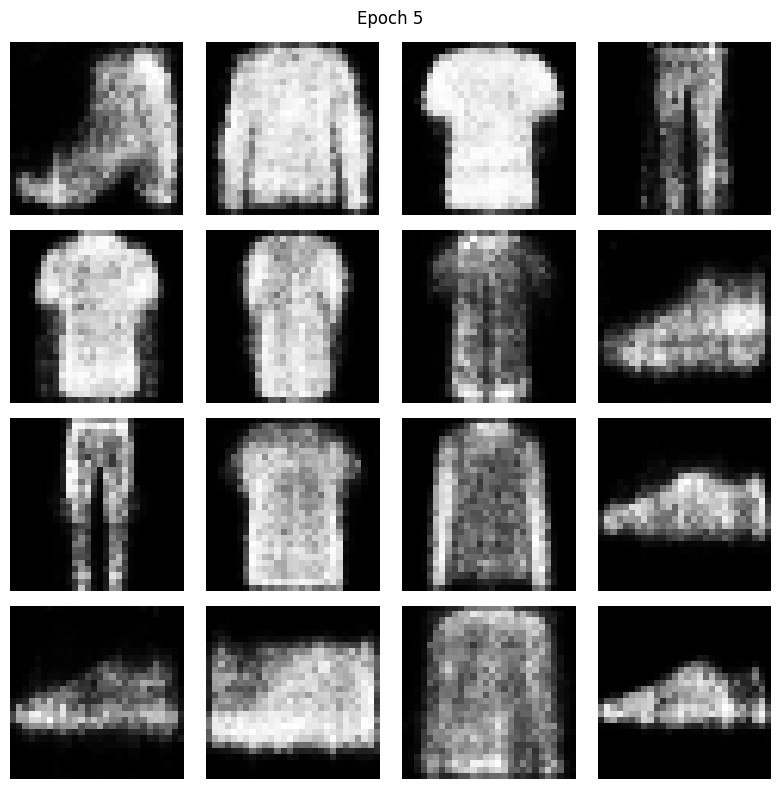

[Epoch 6/25] [Batch 100/938] [C loss: -0.1947] [G loss: -0.4302]
[Epoch 6/25] [Batch 200/938] [C loss: -0.3694] [G loss: 0.1145]
[Epoch 6/25] [Batch 300/938] [C loss: -0.2138] [G loss: -0.2271]
[Epoch 6/25] [Batch 400/938] [C loss: -0.2073] [G loss: 0.5251]
[Epoch 6/25] [Batch 500/938] [C loss: -0.1977] [G loss: -0.7574]
[Epoch 6/25] [Batch 600/938] [C loss: -0.4290] [G loss: 0.6832]
[Epoch 6/25] [Batch 700/938] [C loss: -0.1993] [G loss: 0.4374]
[Epoch 6/25] [Batch 800/938] [C loss: -0.2563] [G loss: -0.7086]
[Epoch 6/25] [Batch 900/938] [C loss: -0.4128] [G loss: -0.4093]
[Epoch 7/25] [Batch 100/938] [C loss: -0.1474] [G loss: -0.0916]
[Epoch 7/25] [Batch 200/938] [C loss: -0.5044] [G loss: 0.5600]
[Epoch 7/25] [Batch 300/938] [C loss: -0.2311] [G loss: 0.2138]
[Epoch 7/25] [Batch 400/938] [C loss: -0.2793] [G loss: 0.4834]
[Epoch 7/25] [Batch 500/938] [C loss: -0.2833] [G loss: -0.9698]
[Epoch 7/25] [Batch 600/938] [C loss: -0.2410] [G loss: -0.2310]
[Epoch 7/25] [Batch 700/938] [C 

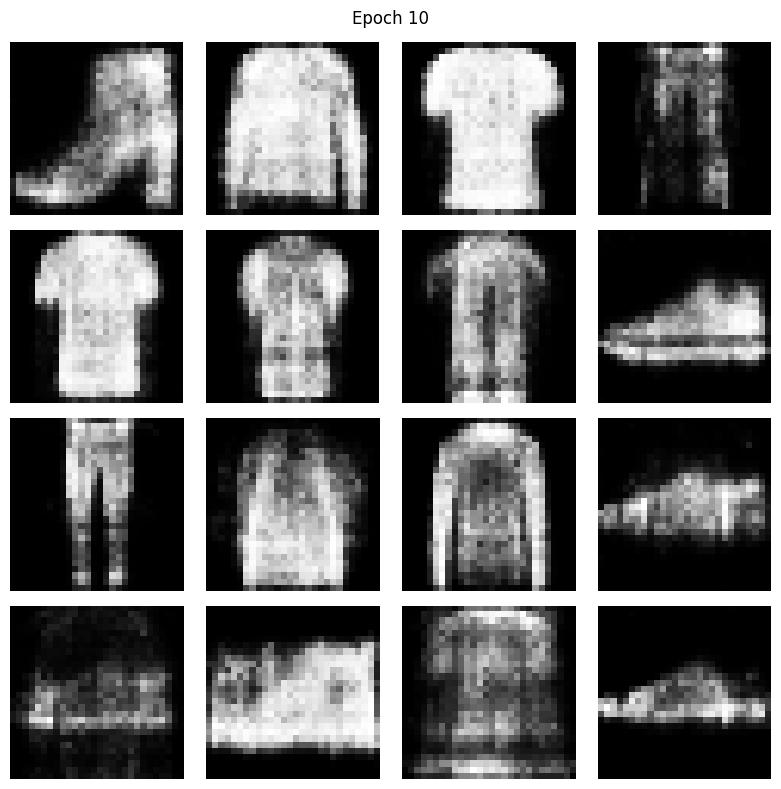

[Epoch 11/25] [Batch 100/938] [C loss: -0.3890] [G loss: -1.0408]
[Epoch 11/25] [Batch 200/938] [C loss: -0.1877] [G loss: -0.0439]
[Epoch 11/25] [Batch 300/938] [C loss: -0.1448] [G loss: -0.7784]
[Epoch 11/25] [Batch 400/938] [C loss: -0.2153] [G loss: 0.0800]
[Epoch 11/25] [Batch 500/938] [C loss: -0.2249] [G loss: -0.3004]
[Epoch 11/25] [Batch 600/938] [C loss: -0.2663] [G loss: -0.6554]
[Epoch 11/25] [Batch 700/938] [C loss: -0.3297] [G loss: 0.7277]
[Epoch 11/25] [Batch 800/938] [C loss: -0.2074] [G loss: -0.4901]
[Epoch 11/25] [Batch 900/938] [C loss: -0.2311] [G loss: -0.6267]
[Epoch 12/25] [Batch 100/938] [C loss: -0.2644] [G loss: -1.0610]
[Epoch 12/25] [Batch 200/938] [C loss: -0.2095] [G loss: -0.6414]
[Epoch 12/25] [Batch 300/938] [C loss: -0.1107] [G loss: 0.4894]
[Epoch 12/25] [Batch 400/938] [C loss: -0.1493] [G loss: -0.3959]
[Epoch 12/25] [Batch 500/938] [C loss: -0.1352] [G loss: -0.2469]
[Epoch 12/25] [Batch 600/938] [C loss: -0.2147] [G loss: -0.8420]
[Epoch 12/25]

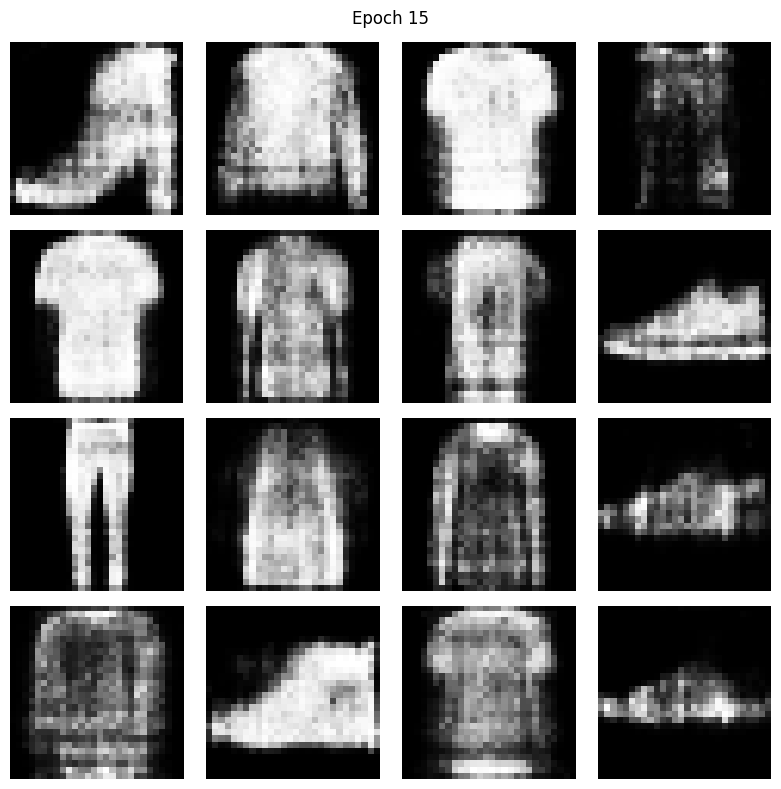

[Epoch 16/25] [Batch 100/938] [C loss: -0.1081] [G loss: 0.8234]
[Epoch 16/25] [Batch 200/938] [C loss: -0.1130] [G loss: 0.3533]
[Epoch 16/25] [Batch 300/938] [C loss: -0.0780] [G loss: -0.7476]
[Epoch 16/25] [Batch 400/938] [C loss: -0.0586] [G loss: 0.6754]
[Epoch 16/25] [Batch 500/938] [C loss: -0.1915] [G loss: -0.3513]
[Epoch 16/25] [Batch 600/938] [C loss: -0.1920] [G loss: -0.9766]
[Epoch 16/25] [Batch 700/938] [C loss: -0.1872] [G loss: -1.3398]
[Epoch 16/25] [Batch 800/938] [C loss: -0.1318] [G loss: -0.3553]
[Epoch 16/25] [Batch 900/938] [C loss: -0.1847] [G loss: -0.6892]
[Epoch 17/25] [Batch 100/938] [C loss: -0.2229] [G loss: -0.3456]
[Epoch 17/25] [Batch 200/938] [C loss: -0.1460] [G loss: -0.7995]
[Epoch 17/25] [Batch 300/938] [C loss: -0.1293] [G loss: 0.1543]
[Epoch 17/25] [Batch 400/938] [C loss: -0.0739] [G loss: -1.1220]
[Epoch 17/25] [Batch 500/938] [C loss: -0.3084] [G loss: 1.2540]
[Epoch 17/25] [Batch 600/938] [C loss: -0.1326] [G loss: 0.1911]
[Epoch 17/25] [B

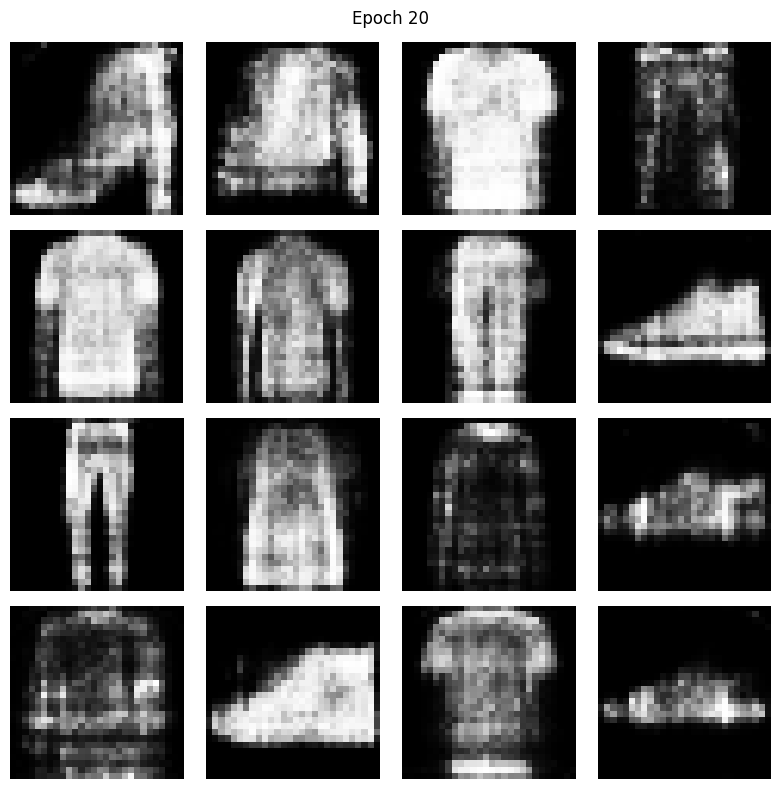

[Epoch 21/25] [Batch 100/938] [C loss: -0.2640] [G loss: 0.6266]
[Epoch 21/25] [Batch 200/938] [C loss: -0.1781] [G loss: 0.6247]
[Epoch 21/25] [Batch 300/938] [C loss: -0.2325] [G loss: -0.3584]
[Epoch 21/25] [Batch 400/938] [C loss: -0.1835] [G loss: -1.0333]
[Epoch 21/25] [Batch 500/938] [C loss: -0.2578] [G loss: -1.9359]
[Epoch 21/25] [Batch 600/938] [C loss: -0.1720] [G loss: -0.3454]
[Epoch 21/25] [Batch 700/938] [C loss: -0.1511] [G loss: 0.7499]
[Epoch 21/25] [Batch 800/938] [C loss: -0.0400] [G loss: -0.6511]
[Epoch 21/25] [Batch 900/938] [C loss: -0.3364] [G loss: 0.8124]
[Epoch 22/25] [Batch 100/938] [C loss: -0.1330] [G loss: -0.1184]
[Epoch 22/25] [Batch 200/938] [C loss: -0.0507] [G loss: -0.7826]
[Epoch 22/25] [Batch 300/938] [C loss: -0.4327] [G loss: 0.6495]
[Epoch 22/25] [Batch 400/938] [C loss: -0.1280] [G loss: 0.0835]
[Epoch 22/25] [Batch 500/938] [C loss: -0.1085] [G loss: -0.9419]
[Epoch 22/25] [Batch 600/938] [C loss: -0.0797] [G loss: -0.1824]
[Epoch 22/25] [B

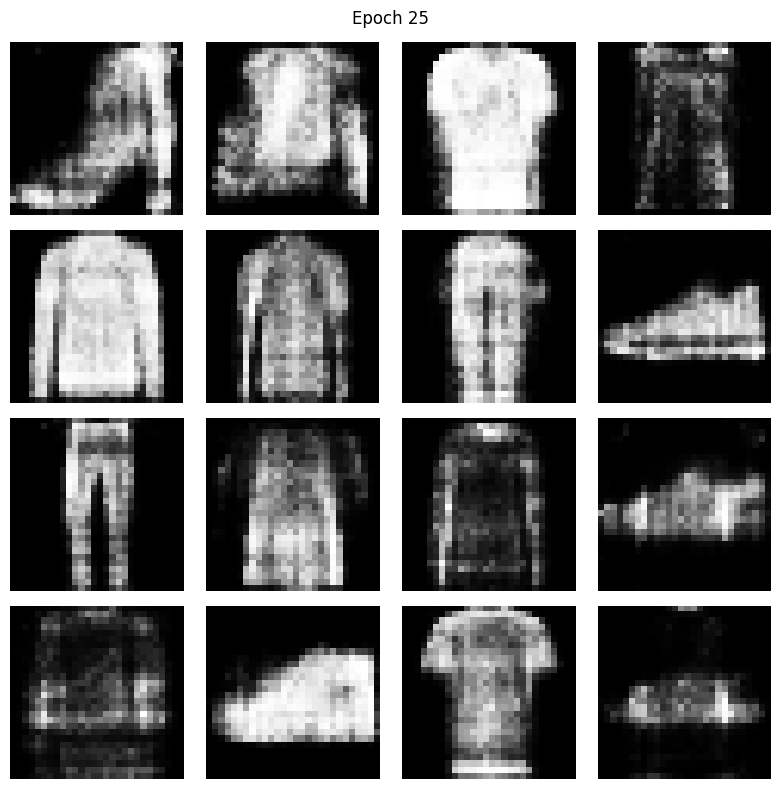

In [19]:
G_losses = []
C_losses = []

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        
        real_imgs = images.view(batch_size, -1)
        # нормализация для tanh: [0,1] -> [-1,1]
        real_imgs = real_imgs * 2 - 1  
        
        '''
          Critic stage: maximize C(x) - C(G(z))
          Or minimize -(C(x) - C(G(z)))
        '''
        for _ in range(config.n_critic):
            critic.zero_grad()
            
            real_validity = critic(real_imgs)

            noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
            fake_imgs = generator(noise)
            fake_validity = critic(fake_imgs.detach())
            
            # Wasserstein loss: -E[C(x)] + E[C(G(z))]
            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
            
            c_loss.backward()
            optim_C.step()
            
            clip_weights(critic, config.clip_value)
        
        '''
          Generator stage: maximize C(G(z)) 
          Or minimaze -C(G(z)) 
        '''
        generator.zero_grad()
        
        noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
        fake_imgs = generator(noise)
        fake_validity = critic(fake_imgs)
        
        # Wasserstein loss: minimaze -E[C(G(z))]
        g_loss = -torch.mean(fake_validity)
        
        g_loss.backward()
        optim_G.step()
        
        G_losses.append(g_loss.item())
        C_losses.append(c_loss.item())
        
        if (iteration + 1) % config.print_freq == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [C loss: %.4f] [G loss: %.4f]'
                  % (epoch + 1, config.num_epochs, iteration + 1, len(dataloader),
                     c_loss.item(), g_loss.item()))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach()
            # денормализация: [-1,1] -> [0,1]
            fake = (fake + 1) / 2
            
            plt.figure(figsize=(8, 8))
            for i in range(min(16, fake.size(0))):
                plt.subplot(4, 4, i + 1)
                plt.imshow(fake[i].numpy().reshape(28, 28), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Epoch {epoch + 1}')
            plt.tight_layout()
            plt.show()

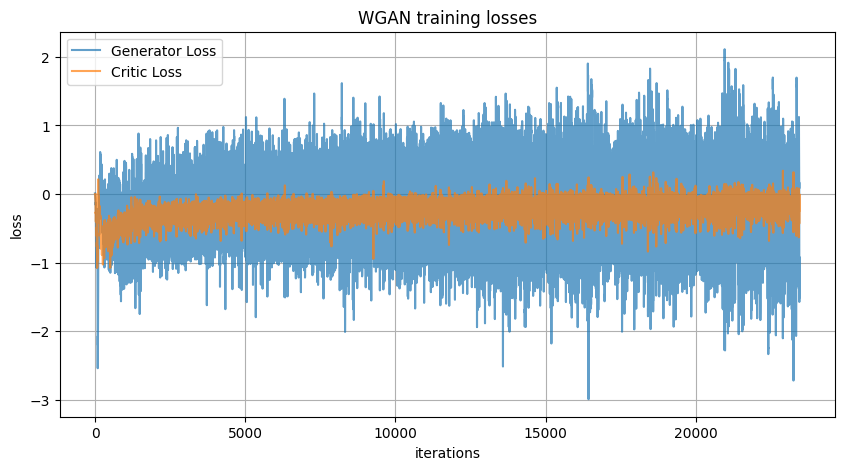

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss', alpha=0.7)
plt.plot(C_losses, label='Critic Loss', alpha=0.7)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.title('WGAN training losses')
plt.grid(True)
plt.show()

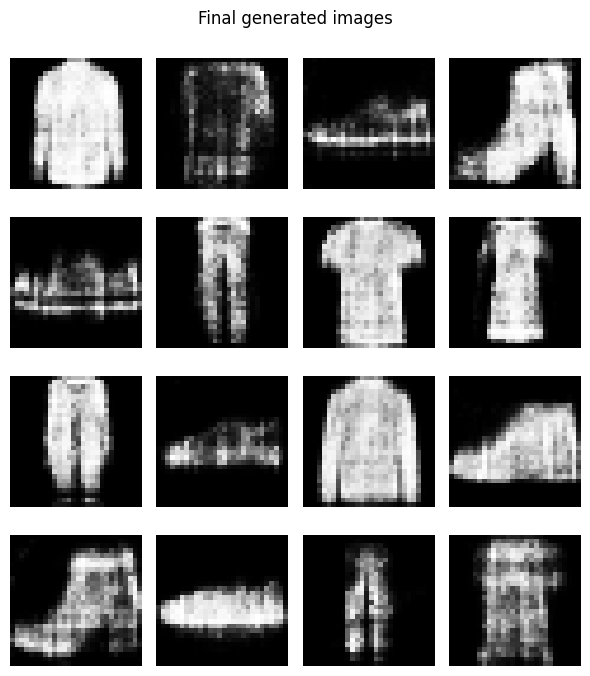

In [27]:
with torch.no_grad():
    noise = torch.FloatTensor(16, config.noise_size).normal_(0, 1)
    fake = generator(noise).detach()
    fake = (fake + 1) / 2  
    
    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Final generated images')
    plt.tight_layout()
    plt.show()

### 2. Wasserstein GAN with gradient penalty

В конфиг добавляется коэффициент gradient penalty и немного увеличивается lr. Добавим к critic loss gradient penalty для обеспечения условия Липшица

In [29]:
from torch.nn.utils import spectral_norm

In [164]:
config.lambda_gp = 10
config.lr = 0.0001

In [173]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_samples)  
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

In [165]:
class CriticSN(nn.Module):
    def __init__(self):
        super(CriticSN, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [166]:
generator = Generator()
critic = CriticSN()

In [167]:
optim_G = torch.optim.Adam(generator.parameters(), lr=config.lr, betas=(0.5, 0.9))
optim_C = torch.optim.Adam(critic.parameters(), lr=config.lr, betas=(0.5, 0.9))

In [168]:
fixed_noise = torch.FloatTensor(64, config.noise_size).normal_(0, 1)

[Epoch 1/25] [Batch 100/938] [C loss: -8.3605] [G loss: -5.9043]
[Epoch 1/25] [Batch 200/938] [C loss: -3.9467] [G loss: -6.2653]
[Epoch 1/25] [Batch 300/938] [C loss: -3.3921] [G loss: -2.3132]
[Epoch 1/25] [Batch 400/938] [C loss: -3.7622] [G loss: -1.4970]
[Epoch 1/25] [Batch 500/938] [C loss: -3.8984] [G loss: -1.0793]
[Epoch 1/25] [Batch 600/938] [C loss: -3.7890] [G loss: -3.7872]
[Epoch 1/25] [Batch 700/938] [C loss: -3.4055] [G loss: -0.0386]
[Epoch 1/25] [Batch 800/938] [C loss: -3.7802] [G loss: -0.7723]
[Epoch 1/25] [Batch 900/938] [C loss: -3.8765] [G loss: -1.4930]
[Epoch 2/25] [Batch 100/938] [C loss: -3.5339] [G loss: -1.8643]
[Epoch 2/25] [Batch 200/938] [C loss: -3.1619] [G loss: 0.6144]
[Epoch 2/25] [Batch 300/938] [C loss: -3.0720] [G loss: -2.1002]
[Epoch 2/25] [Batch 400/938] [C loss: -2.7817] [G loss: -3.0114]
[Epoch 2/25] [Batch 500/938] [C loss: -3.7757] [G loss: -3.5430]
[Epoch 2/25] [Batch 600/938] [C loss: -2.8035] [G loss: -2.1087]
[Epoch 2/25] [Batch 700/93

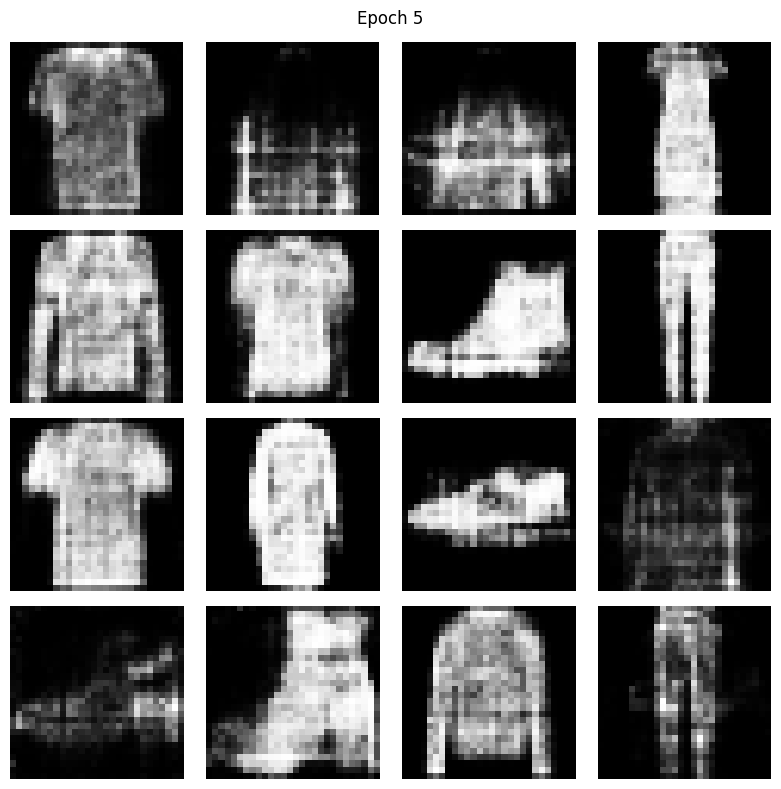

[Epoch 6/25] [Batch 100/938] [C loss: -3.2196] [G loss: -3.1466]
[Epoch 6/25] [Batch 200/938] [C loss: -1.5274] [G loss: -3.4006]
[Epoch 6/25] [Batch 300/938] [C loss: -1.7044] [G loss: -2.1485]
[Epoch 6/25] [Batch 400/938] [C loss: -2.5040] [G loss: -3.7334]
[Epoch 6/25] [Batch 500/938] [C loss: -1.4338] [G loss: -2.9589]
[Epoch 6/25] [Batch 600/938] [C loss: -3.1508] [G loss: -5.3761]
[Epoch 6/25] [Batch 700/938] [C loss: -2.0495] [G loss: -3.6007]
[Epoch 6/25] [Batch 800/938] [C loss: -2.7565] [G loss: -4.2078]
[Epoch 6/25] [Batch 900/938] [C loss: -2.5616] [G loss: -2.9053]
[Epoch 7/25] [Batch 100/938] [C loss: -3.6751] [G loss: -1.2230]
[Epoch 7/25] [Batch 200/938] [C loss: -2.2357] [G loss: -3.9351]
[Epoch 7/25] [Batch 300/938] [C loss: -2.1932] [G loss: -3.5009]
[Epoch 7/25] [Batch 400/938] [C loss: -2.4741] [G loss: -3.5086]
[Epoch 7/25] [Batch 500/938] [C loss: -2.7991] [G loss: -2.8231]
[Epoch 7/25] [Batch 600/938] [C loss: -2.0137] [G loss: -3.5998]
[Epoch 7/25] [Batch 700/9

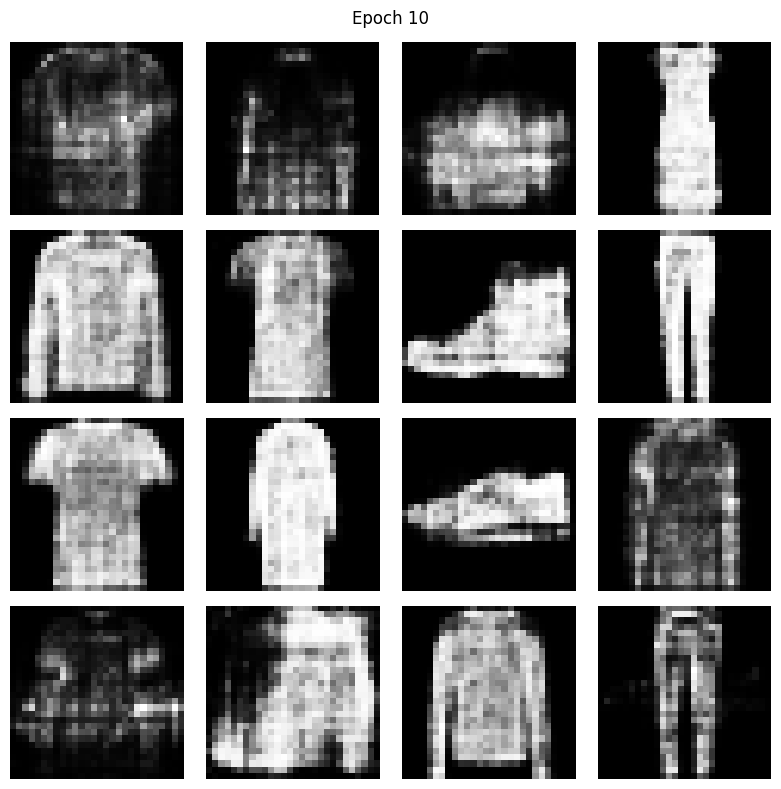

[Epoch 11/25] [Batch 100/938] [C loss: -1.5873] [G loss: -2.4070]
[Epoch 11/25] [Batch 200/938] [C loss: -1.7326] [G loss: -2.4093]
[Epoch 11/25] [Batch 300/938] [C loss: -2.6864] [G loss: 0.7197]
[Epoch 11/25] [Batch 400/938] [C loss: -2.7143] [G loss: -3.0640]
[Epoch 11/25] [Batch 500/938] [C loss: -2.5779] [G loss: -2.4270]
[Epoch 11/25] [Batch 600/938] [C loss: -2.0389] [G loss: -2.6971]
[Epoch 11/25] [Batch 700/938] [C loss: -2.1089] [G loss: -2.1250]
[Epoch 11/25] [Batch 800/938] [C loss: -2.0672] [G loss: -2.7963]
[Epoch 11/25] [Batch 900/938] [C loss: -1.6318] [G loss: 1.3624]
[Epoch 12/25] [Batch 100/938] [C loss: -2.8174] [G loss: -1.1706]
[Epoch 12/25] [Batch 200/938] [C loss: -2.9706] [G loss: -0.8772]
[Epoch 12/25] [Batch 300/938] [C loss: -2.0518] [G loss: -2.0884]
[Epoch 12/25] [Batch 400/938] [C loss: -1.6198] [G loss: 0.2417]
[Epoch 12/25] [Batch 500/938] [C loss: -1.8831] [G loss: -3.3755]
[Epoch 12/25] [Batch 600/938] [C loss: -1.7301] [G loss: -1.0540]
[Epoch 12/25]

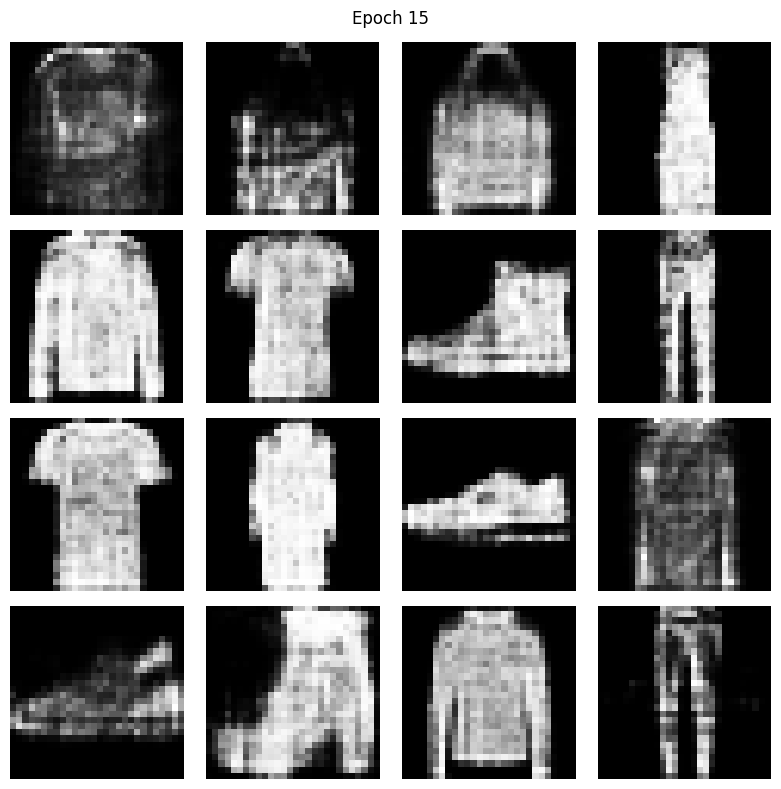

[Epoch 16/25] [Batch 100/938] [C loss: -1.2135] [G loss: -2.6329]
[Epoch 16/25] [Batch 200/938] [C loss: -2.3185] [G loss: -2.5758]
[Epoch 16/25] [Batch 300/938] [C loss: -1.8298] [G loss: -1.7120]
[Epoch 16/25] [Batch 400/938] [C loss: -2.2261] [G loss: -4.5978]
[Epoch 16/25] [Batch 500/938] [C loss: -2.0689] [G loss: -1.7547]
[Epoch 16/25] [Batch 600/938] [C loss: -1.7989] [G loss: -0.5849]
[Epoch 16/25] [Batch 700/938] [C loss: -2.1817] [G loss: -4.6364]
[Epoch 16/25] [Batch 800/938] [C loss: -1.2982] [G loss: -2.4988]
[Epoch 16/25] [Batch 900/938] [C loss: -1.8587] [G loss: -1.5609]
[Epoch 17/25] [Batch 100/938] [C loss: -1.3811] [G loss: 0.2516]
[Epoch 17/25] [Batch 200/938] [C loss: -1.7244] [G loss: -0.7964]
[Epoch 17/25] [Batch 300/938] [C loss: -1.3994] [G loss: -0.4980]
[Epoch 17/25] [Batch 400/938] [C loss: -1.5512] [G loss: 0.5757]
[Epoch 17/25] [Batch 500/938] [C loss: -1.4836] [G loss: -3.7923]
[Epoch 17/25] [Batch 600/938] [C loss: -1.1575] [G loss: 0.4750]
[Epoch 17/25]

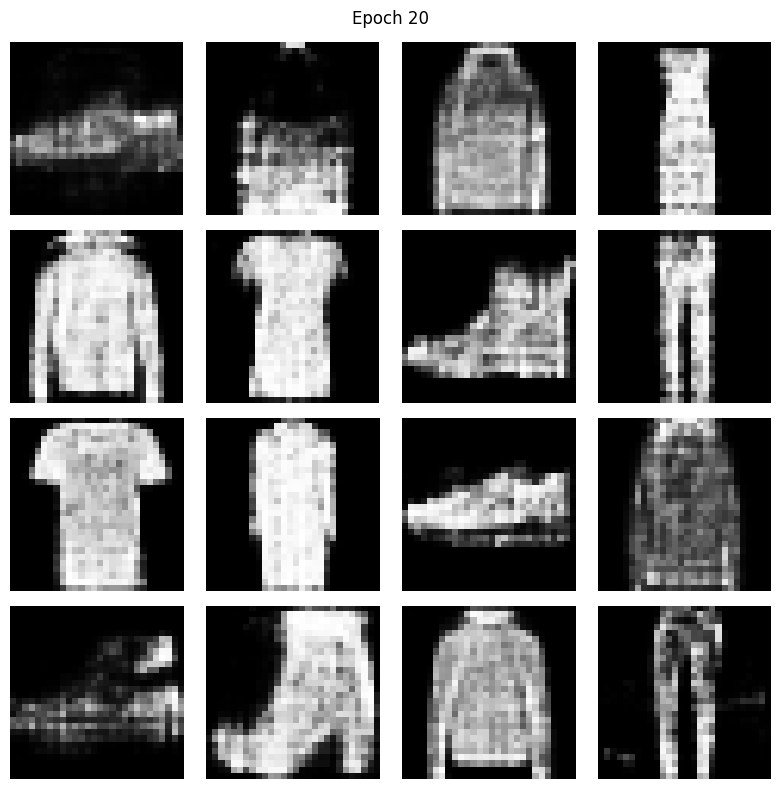

[Epoch 21/25] [Batch 100/938] [C loss: -1.6601] [G loss: -3.8178]
[Epoch 21/25] [Batch 200/938] [C loss: -1.4972] [G loss: -2.8509]
[Epoch 21/25] [Batch 300/938] [C loss: -2.3907] [G loss: -3.8400]
[Epoch 21/25] [Batch 400/938] [C loss: -1.7929] [G loss: -1.1171]
[Epoch 21/25] [Batch 500/938] [C loss: -1.5829] [G loss: 0.4927]
[Epoch 21/25] [Batch 600/938] [C loss: -1.7516] [G loss: 0.4890]
[Epoch 21/25] [Batch 700/938] [C loss: -1.7120] [G loss: -3.9228]
[Epoch 21/25] [Batch 800/938] [C loss: -1.4873] [G loss: -1.9345]
[Epoch 21/25] [Batch 900/938] [C loss: -1.3019] [G loss: -2.8759]
[Epoch 22/25] [Batch 100/938] [C loss: -1.2716] [G loss: 1.3906]
[Epoch 22/25] [Batch 200/938] [C loss: -1.3369] [G loss: -2.8710]
[Epoch 22/25] [Batch 300/938] [C loss: -1.6391] [G loss: 1.4743]
[Epoch 22/25] [Batch 400/938] [C loss: -2.3938] [G loss: -0.9406]
[Epoch 22/25] [Batch 500/938] [C loss: -0.7610] [G loss: -3.7340]
[Epoch 22/25] [Batch 600/938] [C loss: -2.0994] [G loss: -0.3849]
[Epoch 22/25] 

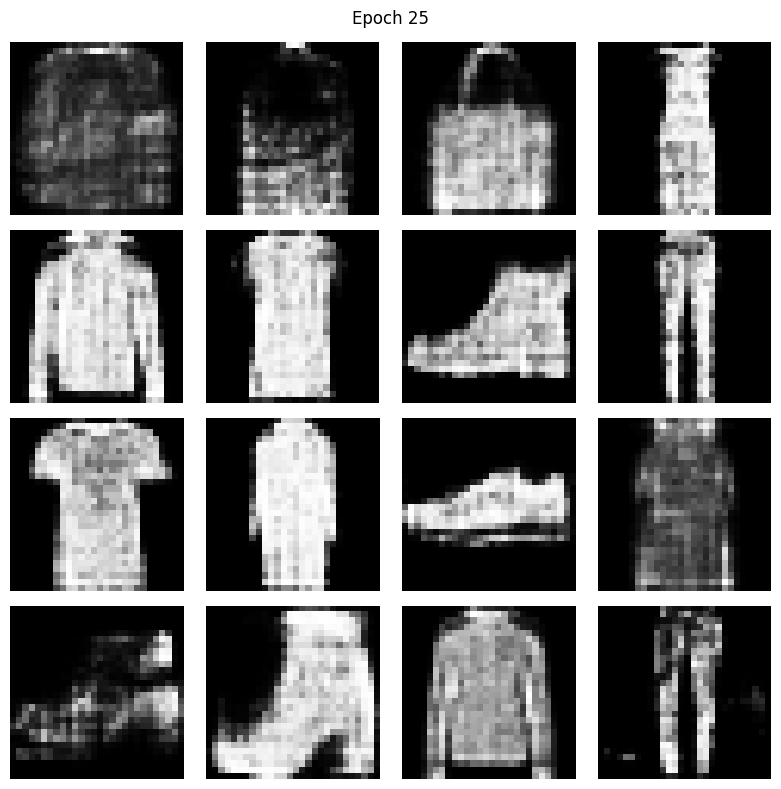

In [170]:
G_losses = []
C_losses = []

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        
        real_imgs = images.view(batch_size, -1)
        real_imgs = real_imgs * 2 - 1  
        
        '''
          Critic stage: maximize C(x) - C(G(z))
          Or minimize -(C(x) - C(G(z)))
        '''
        for _ in range(config.n_critic):
            critic.zero_grad()
            
            real_validity = critic(real_imgs)
            
            noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
            fake_imgs = generator(noise)
            fake_validity = critic(fake_imgs.detach())

            gp = compute_gradient_penalty(critic, real_imgs, fake_imgs.detach())
            
            # Wasserstein loss + gp: -E[C(x)] + E[C(G(z))]
            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + config.lambda_gp * gp
            
            c_loss.backward()
            optim_C.step()
        
        '''
          Generator stage: maximize C(G(z)) 
          Or minimaze -C(G(z)) 
        '''
        generator.zero_grad()
        
        noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
        fake_imgs = generator(noise)
        fake_validity = critic(fake_imgs)
        
        # Wasserstein loss: minimaze -E[C(G(z))]
        g_loss = -torch.mean(fake_validity)
        
        g_loss.backward()
        optim_G.step()
        
        G_losses.append(g_loss.item())
        C_losses.append(c_loss.item())
        
        if (iteration + 1) % config.print_freq == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [C loss: %.4f] [G loss: %.4f]'
                  % (epoch + 1, config.num_epochs, iteration + 1, len(dataloader),
                     c_loss.item(), g_loss.item()))
            
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach()
            fake = (fake + 1) / 2
            
            plt.figure(figsize=(8, 8))
            for i in range(min(16, fake.size(0))):
                plt.subplot(4, 4, i + 1)
                plt.imshow(fake[i].numpy().reshape(28, 28), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Epoch {epoch + 1}')
            plt.tight_layout()
            plt.show()

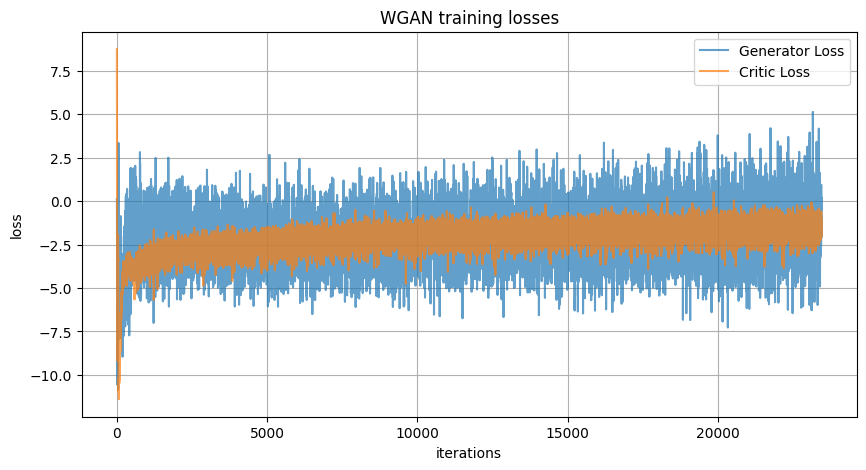

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss', alpha=0.7)
plt.plot(C_losses, label='Critic Loss', alpha=0.7)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.title('WGAN training losses')
plt.grid(True)
plt.show()

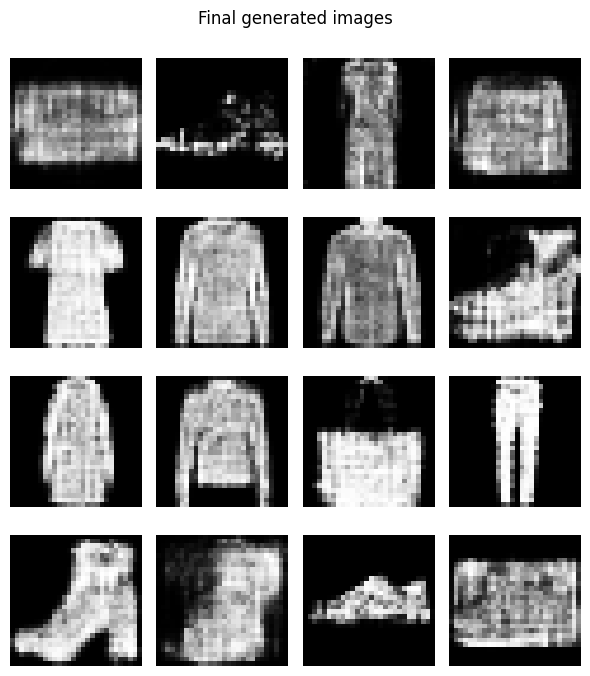

In [172]:
with torch.no_grad():
    noise = torch.FloatTensor(16, config.noise_size).normal_(0, 1)
    fake = generator(noise).detach()
    fake = (fake + 1) / 2  
    
    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Final generated images')
    plt.tight_layout()
    plt.show()

### Выводы

1. График лосса у WGAN менее стабилен, чем у WGAN с grad penalty. Но лосс здесь не является объективным показателем качества.
2. Качество изображений для обычного WGAN как будто +/- такое же, как и для grad penalty. В перспективе grad penalty лучше.

### 3. WGAN c условной генерацией.

Value функция для условной генерации имеет вид:
![img](https://raw.githubusercontent.com/Nustle/VK-Education/main/NN/hw11/value_func.png)

Теперь в генераторе входной шум и y объединяются в совместное скрытое представление. В дискриминаторе x и y представлены как входные данные и как дискриминирующая функция. Т.к. обучаемся на Fashion-MNIST, имеющем 10 классов, то каждую метку класса преобразуем в эмбеддинг, который будут хранить и генератор и дискриминатор. 

In [72]:
from torch.optim.lr_scheduler import ExponentialLR

In [112]:
config.lr = 0.0005
config.num_epochs = 30
config.num_classes = 10
config.n_critic = 5

In [113]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_size=100, num_classes=10):
        super(ConditionalGenerator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.noise_layer = nn.Sequential(
            nn.Linear(noise_size, 256),
            nn.ReLU(inplace=True)
        )
        
        self.condition_layer = nn.Sequential(
            nn.Linear(num_classes, 256),
            nn.ReLU(inplace=True)
        )
        
        self.joint_layer = nn.Sequential(
            nn.Linear(256 + 256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)  # (batch, num_classes)
        
        noise_out = self.noise_layer(noise)  # (batch, 256)
        condition_out = self.condition_layer(label_embedding)  # (batch, 256)
        combined = torch.cat([noise_out, condition_out], dim=1)  # (batch, 512)
        
        output = self.joint_layer(combined)
        return output

В дискриминатор попробуем добавить спектральную нормализацию

In [117]:
class ConditionalCritic(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalCritic, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.image_layer = nn.Sequential(
            spectral_norm(nn.Linear(28*28, 512)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.condition_layer = nn.Sequential(
            spectral_norm(nn.Linear(num_classes, 128)),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.joint_layers = nn.Sequential(
            spectral_norm(nn.Linear(512 + 128, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Linear(256, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            
            spectral_norm(nn.Linear(128, 1))
        )
    
    def forward(self, images, labels):
        label_embedding = self.label_embedding(labels)
        
        image_out = self.image_layer(images)
        condition_out = self.condition_layer(label_embedding)        
        combined = torch.cat([image_out, condition_out], dim=1)
        
        output = self.joint_layers(combined)
        return output

Попробуем добавить learning rate scheduler как в статье. 

In [118]:
def train_conditional_wgan(generator, critic, dataloader, config):
    optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=(0.5, 0.999))
    optim_C = optim.Adam(critic.parameters(), lr=config.lr, betas=(0.5, 0.999))

    scheduler_G = ExponentialLR(optim_G, gamma=0.99996)  
    scheduler_C = ExponentialLR(optim_C, gamma=0.99996)
    
    fixed_noise = torch.FloatTensor(config.num_classes * 10, config.noise_size).normal_(0, 1)
    fixed_labels = torch.LongTensor(np.repeat(np.arange(config.num_classes), 10))
    
    G_losses = []
    C_losses = []
    
    for epoch in range(config.num_epochs):
        for iteration, (images, labels) in enumerate(dataloader):
            batch_size = images.size(0)
            
            real_imgs = images.view(batch_size, -1)
            real_imgs = real_imgs * 2 - 1
            
            # Critic training
            for _ in range(config.n_critic):
                critic.zero_grad()
                
                real_validity = critic(real_imgs, labels)
                
                noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
                fake_labels = torch.LongTensor(np.random.randint(0, config.num_classes, batch_size))
                fake_imgs = generator(noise, fake_labels)
                fake_validity = critic(fake_imgs.detach(), fake_labels)
                
                c_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
                
                c_loss.backward()
                optim_C.step()
            
            # Generator training
            generator.zero_grad()
            
            noise = torch.FloatTensor(batch_size, config.noise_size).normal_(0, 1)
            gen_labels = torch.LongTensor(np.random.randint(0, config.num_classes, batch_size))
            fake_imgs = generator(noise, gen_labels)
            fake_validity = critic(fake_imgs, gen_labels)
            
            g_loss = -torch.mean(fake_validity)
            
            g_loss.backward()
            optim_G.step()

            
            G_losses.append(g_loss.item())
            C_losses.append(c_loss.item())
            
            if (iteration + 1) % config.print_freq == 0:
                print('[Epoch %d/%d] [Batch %d/%d] [C loss: %.4f] [G loss: %.4f]'
                      % (epoch + 1, config.num_epochs, iteration + 1, len(dataloader),
                         c_loss.item(), g_loss.item()))

        scheduler_G.step()
        scheduler_C.step()
        
        if (epoch + 1) % 5 == 0:
            samples_per_class = 3
            fixed_noise = torch.FloatTensor(config.num_classes * samples_per_class, config.noise_size).normal_(0, 1)
            fixed_labels = torch.LongTensor(np.repeat(np.arange(config.num_classes), samples_per_class))
            
            with torch.no_grad():
                fake = generator(fixed_noise, fixed_labels).detach()
                fake = (fake + 1) / 2
                
                class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
                
                fig, axes = plt.subplots(config.num_classes, samples_per_class, figsize=(9, 12))
                
                for i in range(config.num_classes):
                    for j in range(samples_per_class):
                        idx = i * samples_per_class + j
                        axes[i, j].imshow(fake[idx].numpy().reshape(28, 28), cmap='gray')
                        axes[i, j].axis('off')
                    
                    axes[i, 0].text(-0.3, 0.5, class_names[i], transform=axes[i, 0].transAxes, rotation=0, 
                                   verticalalignment='center', horizontalalignment='right', fontsize=11)
                
                plt.suptitle(f'Epoch {epoch + 1} conditional generation', fontsize=14)
                plt.subplots_adjust(left=0.15, wspace=0.05, hspace=0.05)
                plt.show()
    
    return G_losses, C_losses

In [120]:
generator = ConditionalGenerator(noise_size=config.noise_size, num_classes=config.num_classes)
critic = ConditionalCritic(num_classes=config.num_classes)

[Epoch 1/30] [Batch 100/938] [C loss: -2.7768] [G loss: 0.3116]
[Epoch 1/30] [Batch 200/938] [C loss: -2.3278] [G loss: -0.8872]
[Epoch 1/30] [Batch 300/938] [C loss: -1.7351] [G loss: -3.7346]
[Epoch 1/30] [Batch 400/938] [C loss: -1.6447] [G loss: -2.7085]
[Epoch 1/30] [Batch 500/938] [C loss: -1.7849] [G loss: -0.4306]
[Epoch 1/30] [Batch 600/938] [C loss: -1.8685] [G loss: -0.3094]
[Epoch 1/30] [Batch 700/938] [C loss: -0.9674] [G loss: -4.1862]
[Epoch 1/30] [Batch 800/938] [C loss: -1.5814] [G loss: -7.4965]
[Epoch 1/30] [Batch 900/938] [C loss: -1.2515] [G loss: -2.3944]
[Epoch 2/30] [Batch 100/938] [C loss: -0.6180] [G loss: -1.8785]
[Epoch 2/30] [Batch 200/938] [C loss: -0.9358] [G loss: -4.9030]
[Epoch 2/30] [Batch 300/938] [C loss: -0.9838] [G loss: -4.4715]
[Epoch 2/30] [Batch 400/938] [C loss: -1.7761] [G loss: -1.0948]
[Epoch 2/30] [Batch 500/938] [C loss: -2.7631] [G loss: -6.3975]
[Epoch 2/30] [Batch 600/938] [C loss: -1.2355] [G loss: -3.8474]
[Epoch 2/30] [Batch 700/93

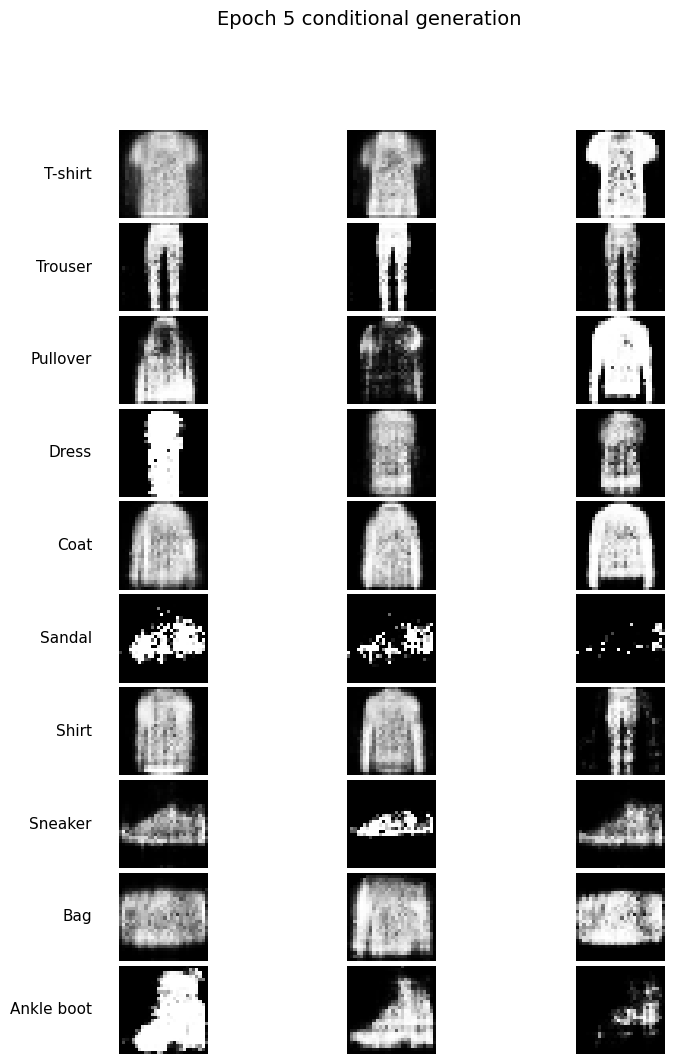

[Epoch 6/30] [Batch 100/938] [C loss: -0.7533] [G loss: -6.6267]
[Epoch 6/30] [Batch 200/938] [C loss: -1.3477] [G loss: -4.0839]
[Epoch 6/30] [Batch 300/938] [C loss: -0.9136] [G loss: -7.0486]
[Epoch 6/30] [Batch 400/938] [C loss: -1.2511] [G loss: -5.5513]
[Epoch 6/30] [Batch 500/938] [C loss: -0.9129] [G loss: -1.6820]
[Epoch 6/30] [Batch 600/938] [C loss: -0.8442] [G loss: -1.0475]
[Epoch 6/30] [Batch 700/938] [C loss: -0.7458] [G loss: -4.7727]
[Epoch 6/30] [Batch 800/938] [C loss: -0.6292] [G loss: -8.5025]
[Epoch 6/30] [Batch 900/938] [C loss: -0.6037] [G loss: -7.3167]
[Epoch 7/30] [Batch 100/938] [C loss: -0.7428] [G loss: -7.2150]
[Epoch 7/30] [Batch 200/938] [C loss: -1.2015] [G loss: -6.6118]
[Epoch 7/30] [Batch 300/938] [C loss: -1.1447] [G loss: -10.3191]
[Epoch 7/30] [Batch 400/938] [C loss: -0.7211] [G loss: -9.6446]
[Epoch 7/30] [Batch 500/938] [C loss: -0.9548] [G loss: -7.6162]
[Epoch 7/30] [Batch 600/938] [C loss: -0.6930] [G loss: -5.7085]
[Epoch 7/30] [Batch 700/

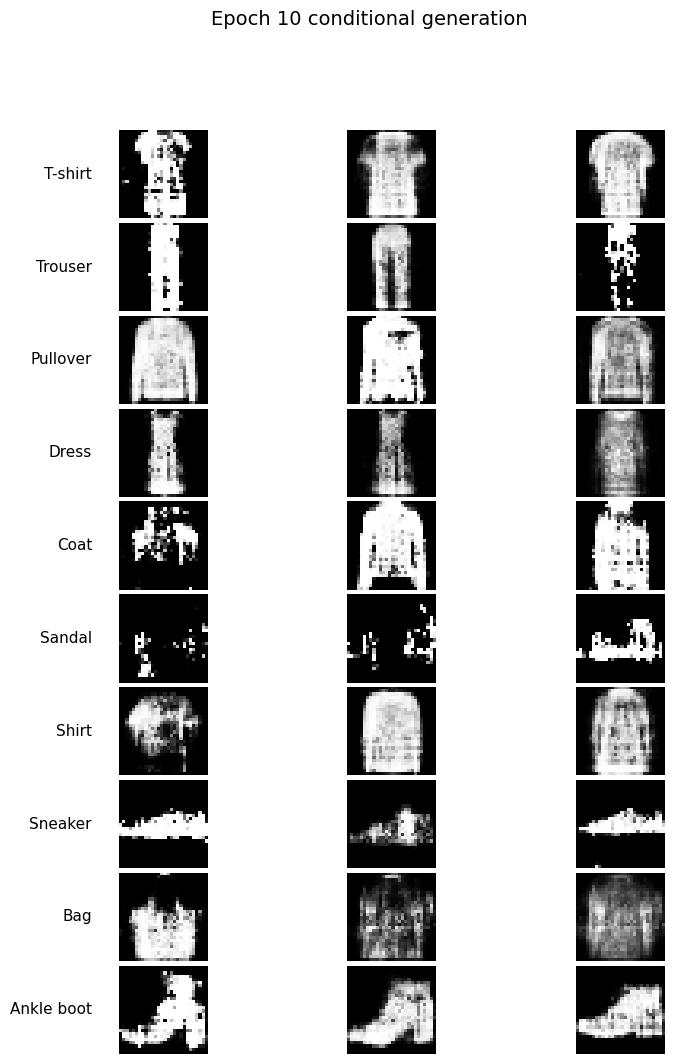

[Epoch 11/30] [Batch 100/938] [C loss: -0.4266] [G loss: -7.5392]
[Epoch 11/30] [Batch 200/938] [C loss: -0.3980] [G loss: -7.6616]
[Epoch 11/30] [Batch 300/938] [C loss: -0.4321] [G loss: -7.9861]
[Epoch 11/30] [Batch 400/938] [C loss: -0.6184] [G loss: -3.1696]
[Epoch 11/30] [Batch 500/938] [C loss: -0.3307] [G loss: -11.9729]
[Epoch 11/30] [Batch 600/938] [C loss: -0.4129] [G loss: -3.3752]
[Epoch 11/30] [Batch 700/938] [C loss: -0.9142] [G loss: -8.4015]
[Epoch 11/30] [Batch 800/938] [C loss: -0.9199] [G loss: -5.3661]
[Epoch 11/30] [Batch 900/938] [C loss: -0.6371] [G loss: -13.0039]
[Epoch 12/30] [Batch 100/938] [C loss: -0.6315] [G loss: -4.9284]
[Epoch 12/30] [Batch 200/938] [C loss: -0.6220] [G loss: -9.7783]
[Epoch 12/30] [Batch 300/938] [C loss: -0.5184] [G loss: -5.3948]
[Epoch 12/30] [Batch 400/938] [C loss: -0.5260] [G loss: -8.3090]
[Epoch 12/30] [Batch 500/938] [C loss: -2.1483] [G loss: -5.0229]
[Epoch 12/30] [Batch 600/938] [C loss: -0.9453] [G loss: -10.0652]
[Epoch 

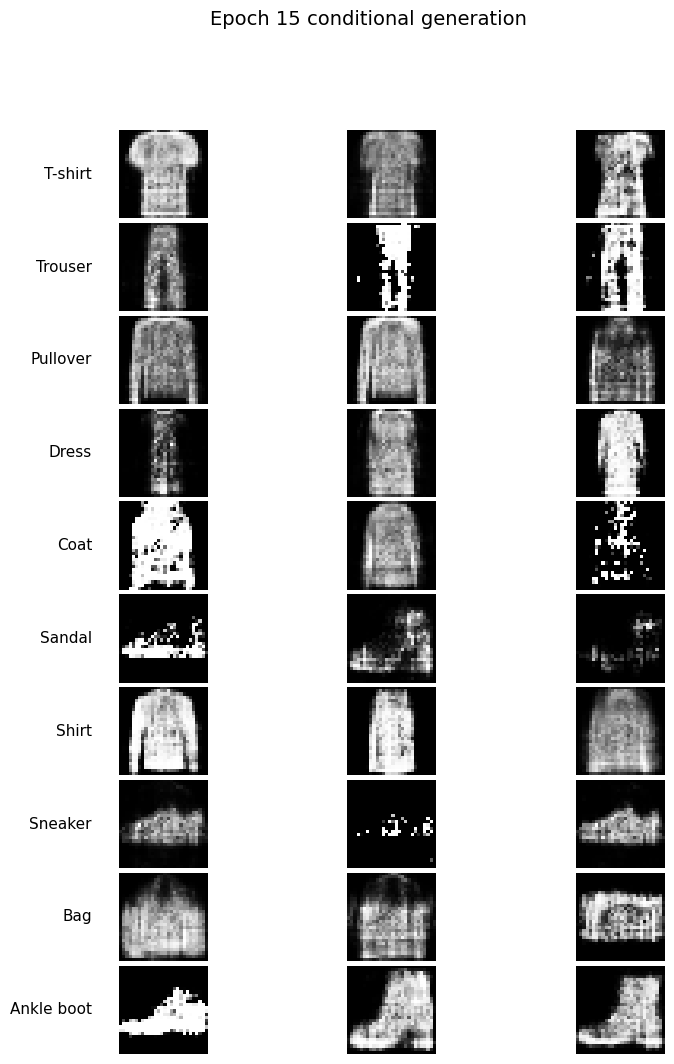

[Epoch 16/30] [Batch 100/938] [C loss: -0.8763] [G loss: -8.3559]
[Epoch 16/30] [Batch 200/938] [C loss: -0.4124] [G loss: -7.9695]
[Epoch 16/30] [Batch 300/938] [C loss: -0.6348] [G loss: -14.1282]
[Epoch 16/30] [Batch 400/938] [C loss: -0.3906] [G loss: -9.6045]
[Epoch 16/30] [Batch 500/938] [C loss: -0.3405] [G loss: -7.2459]
[Epoch 16/30] [Batch 600/938] [C loss: -1.1647] [G loss: -7.9919]
[Epoch 16/30] [Batch 700/938] [C loss: -0.6656] [G loss: -13.3262]
[Epoch 16/30] [Batch 800/938] [C loss: -0.0487] [G loss: -11.5741]
[Epoch 16/30] [Batch 900/938] [C loss: -0.1408] [G loss: -12.6622]
[Epoch 17/30] [Batch 100/938] [C loss: -0.5371] [G loss: -11.9934]
[Epoch 17/30] [Batch 200/938] [C loss: -0.6989] [G loss: -3.6048]
[Epoch 17/30] [Batch 300/938] [C loss: -0.7092] [G loss: -4.9991]
[Epoch 17/30] [Batch 400/938] [C loss: -0.0396] [G loss: -11.4009]
[Epoch 17/30] [Batch 500/938] [C loss: -0.7672] [G loss: -4.4928]
[Epoch 17/30] [Batch 600/938] [C loss: -0.3715] [G loss: -13.0766]
[Ep

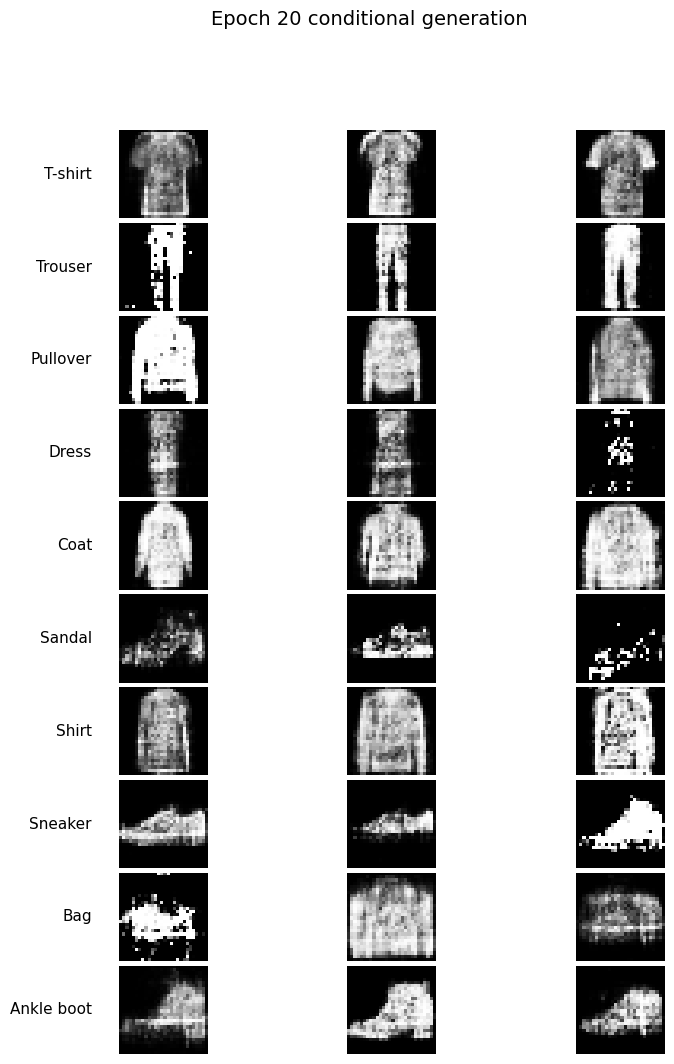

[Epoch 21/30] [Batch 100/938] [C loss: -0.1661] [G loss: -8.4686]
[Epoch 21/30] [Batch 200/938] [C loss: -0.5174] [G loss: -7.7755]
[Epoch 21/30] [Batch 300/938] [C loss: -0.8809] [G loss: -10.5975]
[Epoch 21/30] [Batch 400/938] [C loss: -0.6837] [G loss: -10.1923]
[Epoch 21/30] [Batch 500/938] [C loss: -0.2245] [G loss: -9.7731]
[Epoch 21/30] [Batch 600/938] [C loss: -0.4071] [G loss: -8.3485]
[Epoch 21/30] [Batch 700/938] [C loss: -0.3232] [G loss: -9.0906]
[Epoch 21/30] [Batch 800/938] [C loss: -0.6594] [G loss: -10.5949]
[Epoch 21/30] [Batch 900/938] [C loss: -0.2766] [G loss: -10.5642]
[Epoch 22/30] [Batch 100/938] [C loss: -0.2524] [G loss: -8.1865]
[Epoch 22/30] [Batch 200/938] [C loss: -0.7417] [G loss: -8.0681]
[Epoch 22/30] [Batch 300/938] [C loss: -0.3975] [G loss: -7.5872]
[Epoch 22/30] [Batch 400/938] [C loss: -0.6420] [G loss: -9.4950]
[Epoch 22/30] [Batch 500/938] [C loss: -0.3497] [G loss: -8.1420]
[Epoch 22/30] [Batch 600/938] [C loss: -0.2072] [G loss: -11.0120]
[Epoc

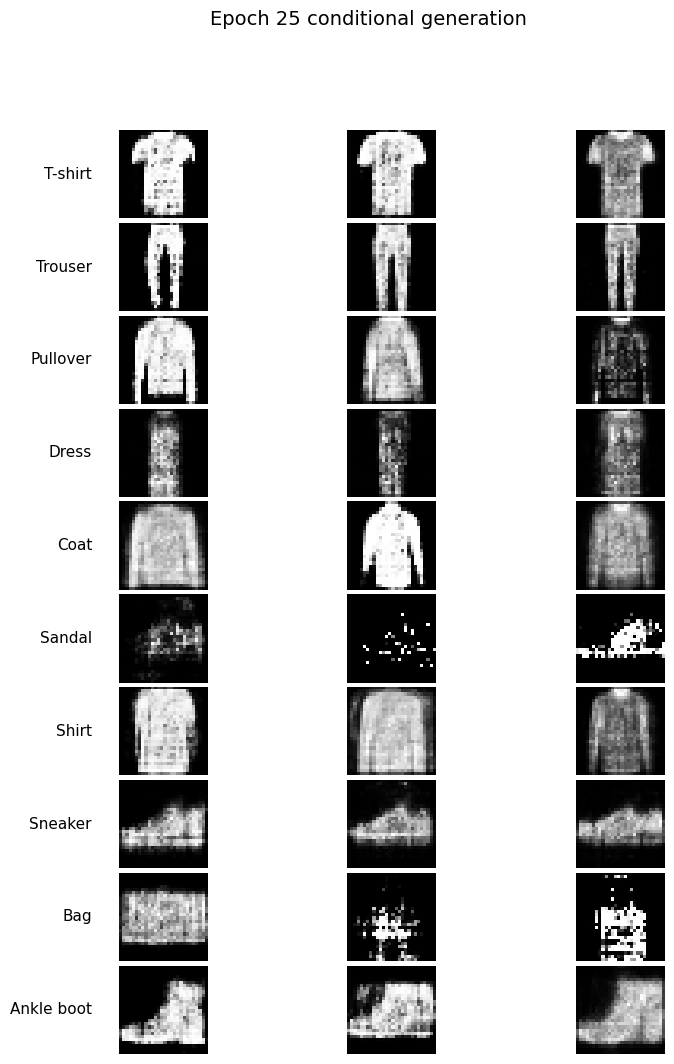

[Epoch 26/30] [Batch 100/938] [C loss: -0.5499] [G loss: -12.6993]
[Epoch 26/30] [Batch 200/938] [C loss: -0.7455] [G loss: -7.4341]
[Epoch 26/30] [Batch 300/938] [C loss: -0.2221] [G loss: -6.8718]
[Epoch 26/30] [Batch 400/938] [C loss: -0.3671] [G loss: -10.3200]
[Epoch 26/30] [Batch 500/938] [C loss: -0.9576] [G loss: -9.9757]
[Epoch 26/30] [Batch 600/938] [C loss: 0.0068] [G loss: -8.4296]
[Epoch 26/30] [Batch 700/938] [C loss: -0.4530] [G loss: -12.7963]
[Epoch 26/30] [Batch 800/938] [C loss: -0.0975] [G loss: -8.1126]
[Epoch 26/30] [Batch 900/938] [C loss: -0.5198] [G loss: -10.0062]
[Epoch 27/30] [Batch 100/938] [C loss: -0.7931] [G loss: -12.1918]
[Epoch 27/30] [Batch 200/938] [C loss: -0.0964] [G loss: -7.1467]
[Epoch 27/30] [Batch 300/938] [C loss: 0.4457] [G loss: -10.0145]
[Epoch 27/30] [Batch 400/938] [C loss: -0.6199] [G loss: -11.0662]
[Epoch 27/30] [Batch 500/938] [C loss: -0.1114] [G loss: -8.6131]
[Epoch 27/30] [Batch 600/938] [C loss: -0.2110] [G loss: -7.7877]
[Epoc

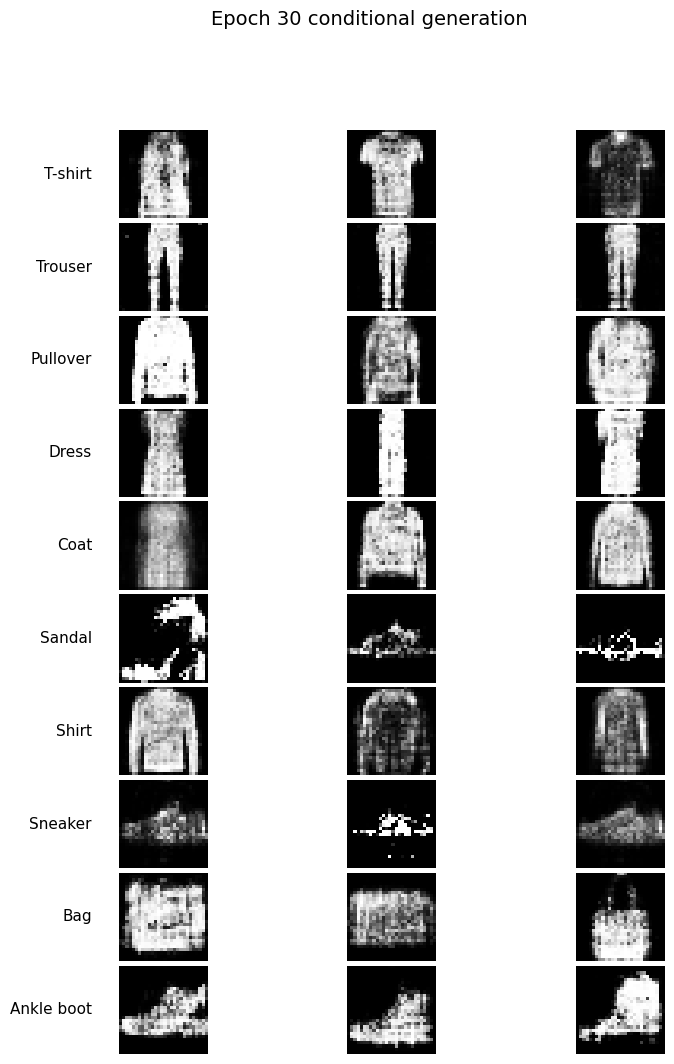

In [121]:
G_losses, C_losses = train_conditional_wgan(generator, critic, dataloader, config)

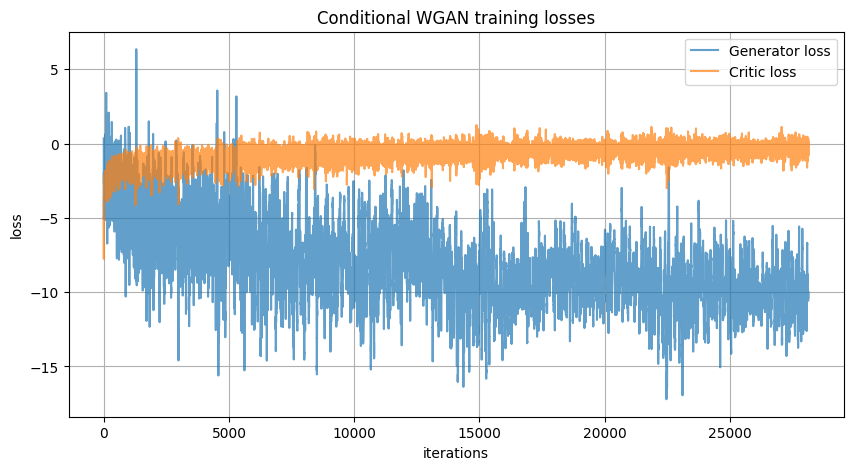

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator loss', alpha=0.7)
plt.plot(C_losses, label='Critic loss', alpha=0.7)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Conditional WGAN training losses')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
def generate_class_samples(generator, class_label, n_samples=2, noise_size=100):
    generator.eval()
    with torch.no_grad():
        noise = torch.FloatTensor(n_samples, noise_size).normal_(0, 1)
        labels = torch.LongTensor([class_label] * n_samples)
        
        fake = generator(noise, labels).detach()
        fake = (fake + 1) / 2
        
        plt.figure(figsize=(8, 8))
        for i in range(n_samples):
            plt.subplot(4, 4, i + 1)
            plt.imshow(fake[i].numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
        
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        
        plt.suptitle(f'generated samples for class: {class_names[class_label]}')
        plt.tight_layout()
        plt.show()

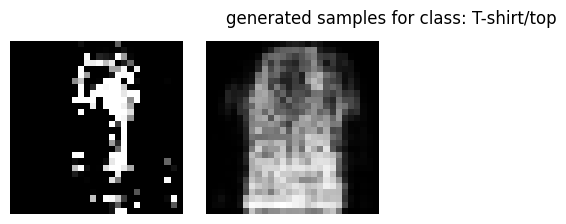

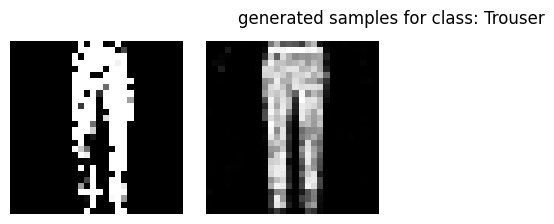

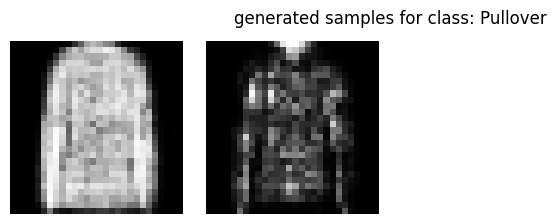

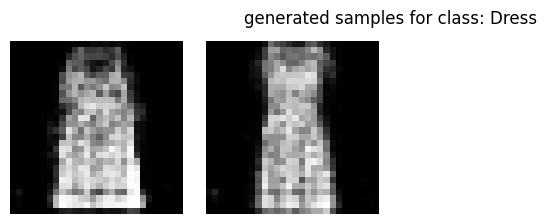

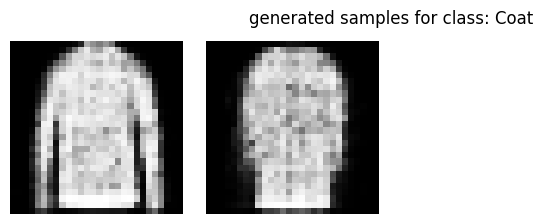

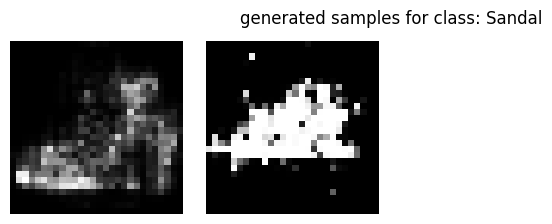

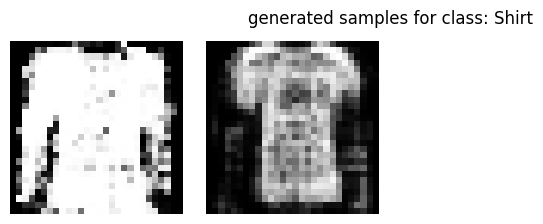

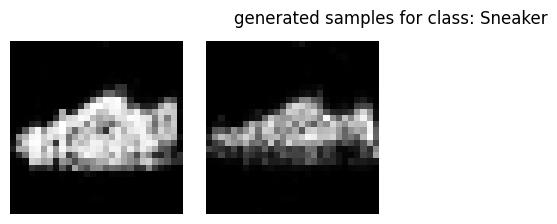

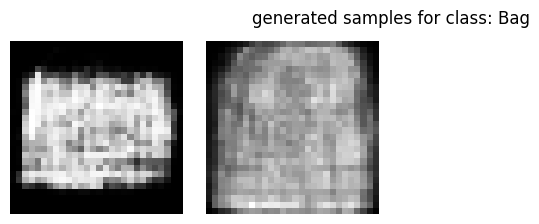

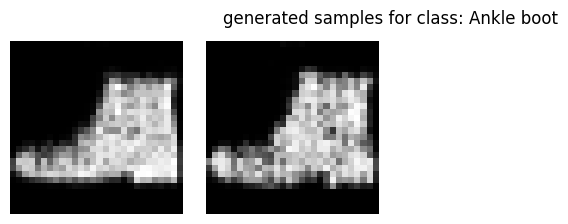

In [128]:
for k in range(10):
    generate_class_samples(generator, k)

Для каких-то классов, например для ankle boot, получилось неплохо. В целом модель уже генерирует изображения +/- соответствующие меткам класса, хоть и с артефактами.

Попробуем генератору и дискриминатору добавить Dropout.

In [131]:
class GeneratorDropout(nn.Module):
    def __init__(self, noise_size=100, num_classes=10):
        super(GeneratorDropout, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.noise_layer = nn.Sequential(
            nn.Linear(noise_size, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)  
        )
        
        self.condition_layer = nn.Sequential(
            nn.Linear(num_classes, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4) 
        )
        
        self.joint_layer = nn.Sequential(
            nn.Linear(256 + 256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  
            
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)
        
        noise_out = self.noise_layer(noise)
        condition_out = self.condition_layer(label_embedding)
        combined = torch.cat([noise_out, condition_out], dim=1)
        
        output = self.joint_layer(combined)
        return output

In [133]:
class CriticDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(CriticDropout, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.image_layer = nn.Sequential(
            spectral_norm(nn.Linear(28*28, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4)  
        )
        
        self.condition_layer = nn.Sequential(
            spectral_norm(nn.Linear(num_classes, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4)  
        )
        
        self.joint_layers = nn.Sequential(
            spectral_norm(nn.Linear(512 + 128, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4), 
            
            spectral_norm(nn.Linear(256, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4), 
            
            spectral_norm(nn.Linear(128, 1))
        )
    
    def forward(self, images, labels):
        label_embedding = self.label_embedding(labels)
        
        image_out = self.image_layer(images)
        condition_out = self.condition_layer(label_embedding)        
        combined = torch.cat([image_out, condition_out], dim=1)
        
        output = self.joint_layers(combined)
        return output

In [135]:
generator_dropout = GeneratorDropout(noise_size=config.noise_size, num_classes=config.num_classes)
critic_dropout = CriticDropout(num_classes=config.num_classes)

[Epoch 1/30] [Batch 100/938] [C loss: -3.2016] [G loss: 0.0061]
[Epoch 1/30] [Batch 200/938] [C loss: -2.5407] [G loss: -1.5325]
[Epoch 1/30] [Batch 300/938] [C loss: -1.4348] [G loss: -4.1771]
[Epoch 1/30] [Batch 400/938] [C loss: -1.5731] [G loss: -1.3086]
[Epoch 1/30] [Batch 500/938] [C loss: -1.1694] [G loss: -3.7125]
[Epoch 1/30] [Batch 600/938] [C loss: -0.5528] [G loss: -2.9609]
[Epoch 1/30] [Batch 700/938] [C loss: -2.0892] [G loss: -2.7093]
[Epoch 1/30] [Batch 800/938] [C loss: -1.1207] [G loss: -4.1794]
[Epoch 1/30] [Batch 900/938] [C loss: -1.3070] [G loss: -3.9487]
[Epoch 2/30] [Batch 100/938] [C loss: -2.1711] [G loss: -3.6886]
[Epoch 2/30] [Batch 200/938] [C loss: -2.1891] [G loss: -0.7094]
[Epoch 2/30] [Batch 300/938] [C loss: -1.3041] [G loss: -2.2615]
[Epoch 2/30] [Batch 400/938] [C loss: -1.3833] [G loss: -4.0383]
[Epoch 2/30] [Batch 500/938] [C loss: -0.3736] [G loss: -5.3968]
[Epoch 2/30] [Batch 600/938] [C loss: -1.1874] [G loss: -3.0521]
[Epoch 2/30] [Batch 700/93

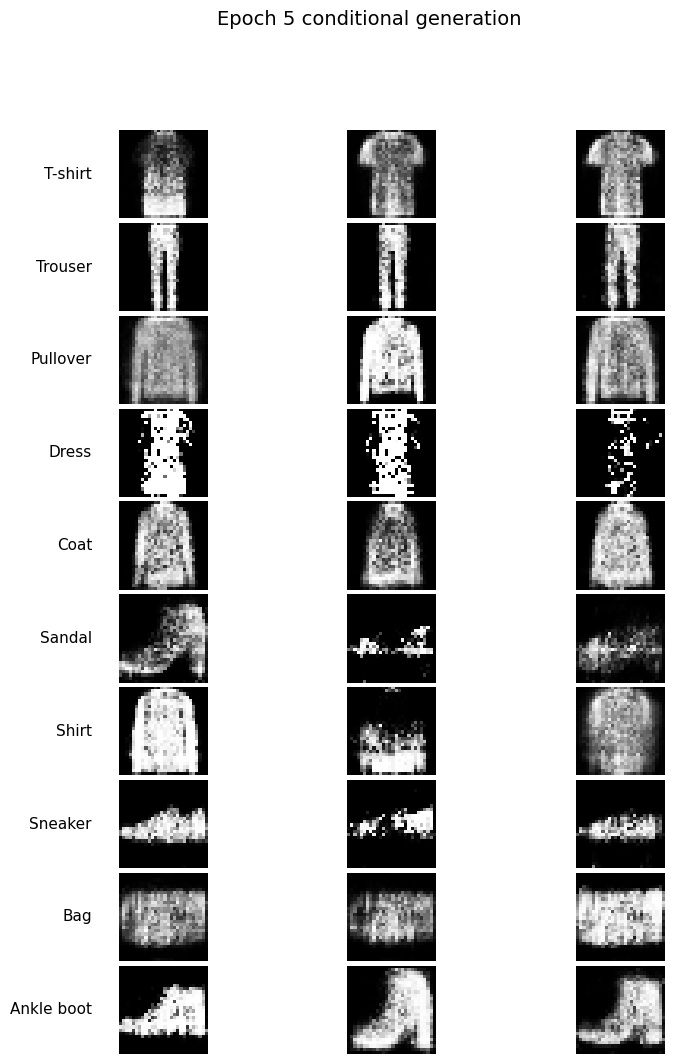

[Epoch 6/30] [Batch 100/938] [C loss: -0.7839] [G loss: -3.1630]
[Epoch 6/30] [Batch 200/938] [C loss: -0.7329] [G loss: 0.2324]
[Epoch 6/30] [Batch 300/938] [C loss: -0.4767] [G loss: -0.0095]
[Epoch 6/30] [Batch 400/938] [C loss: -0.6620] [G loss: -5.8072]
[Epoch 6/30] [Batch 500/938] [C loss: -1.2724] [G loss: -0.6231]
[Epoch 6/30] [Batch 600/938] [C loss: -0.4191] [G loss: -2.4289]
[Epoch 6/30] [Batch 700/938] [C loss: -1.0335] [G loss: -2.4287]
[Epoch 6/30] [Batch 800/938] [C loss: -1.2442] [G loss: -0.0350]
[Epoch 6/30] [Batch 900/938] [C loss: -0.8146] [G loss: -5.1782]
[Epoch 7/30] [Batch 100/938] [C loss: -0.4119] [G loss: -2.4500]
[Epoch 7/30] [Batch 200/938] [C loss: -0.6441] [G loss: 2.7809]
[Epoch 7/30] [Batch 300/938] [C loss: -1.1548] [G loss: -2.2702]
[Epoch 7/30] [Batch 400/938] [C loss: -0.6958] [G loss: -4.2673]
[Epoch 7/30] [Batch 500/938] [C loss: -0.6844] [G loss: -0.9253]
[Epoch 7/30] [Batch 600/938] [C loss: -0.4807] [G loss: -2.5735]
[Epoch 7/30] [Batch 700/938

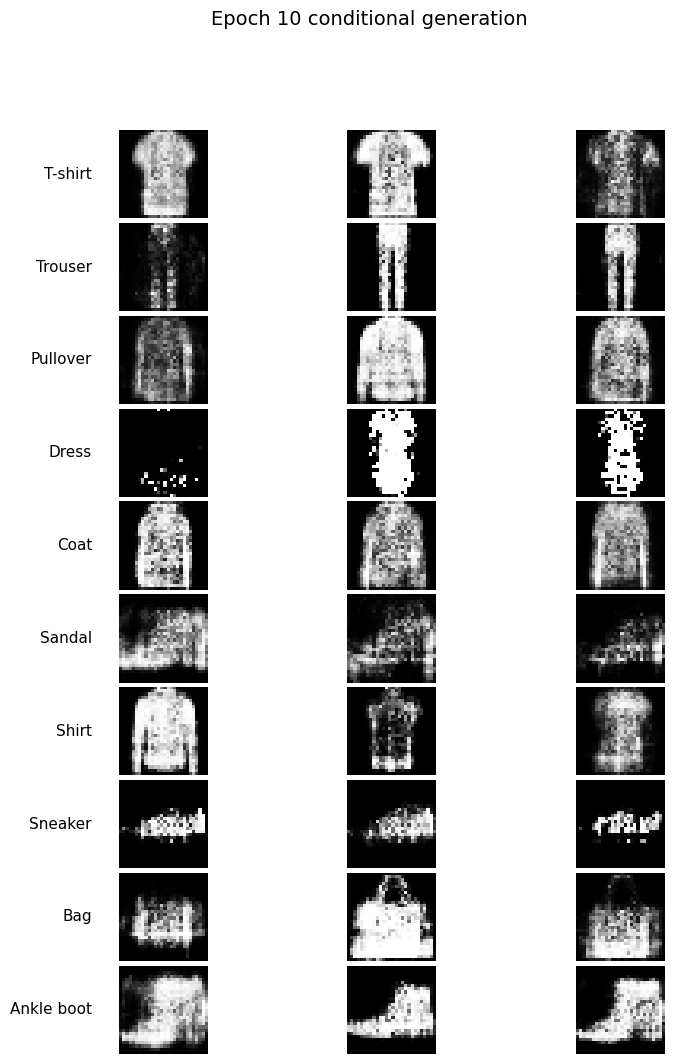

[Epoch 11/30] [Batch 100/938] [C loss: -0.9844] [G loss: -1.0829]
[Epoch 11/30] [Batch 200/938] [C loss: 0.0276] [G loss: 1.0001]
[Epoch 11/30] [Batch 300/938] [C loss: -0.6301] [G loss: -0.5783]
[Epoch 11/30] [Batch 400/938] [C loss: -0.5782] [G loss: -1.0231]
[Epoch 11/30] [Batch 500/938] [C loss: -0.3859] [G loss: 0.2884]
[Epoch 11/30] [Batch 600/938] [C loss: 0.0292] [G loss: 2.6306]
[Epoch 11/30] [Batch 700/938] [C loss: -0.5926] [G loss: -0.9894]
[Epoch 11/30] [Batch 800/938] [C loss: -0.2029] [G loss: 0.5749]
[Epoch 11/30] [Batch 900/938] [C loss: -0.5962] [G loss: -1.6064]
[Epoch 12/30] [Batch 100/938] [C loss: -0.7852] [G loss: 0.0811]
[Epoch 12/30] [Batch 200/938] [C loss: 0.2325] [G loss: 0.5898]
[Epoch 12/30] [Batch 300/938] [C loss: 0.0694] [G loss: -1.8562]
[Epoch 12/30] [Batch 400/938] [C loss: -0.2409] [G loss: 0.8180]
[Epoch 12/30] [Batch 500/938] [C loss: -0.0921] [G loss: -1.6289]
[Epoch 12/30] [Batch 600/938] [C loss: -0.6747] [G loss: -0.2364]
[Epoch 12/30] [Batch 

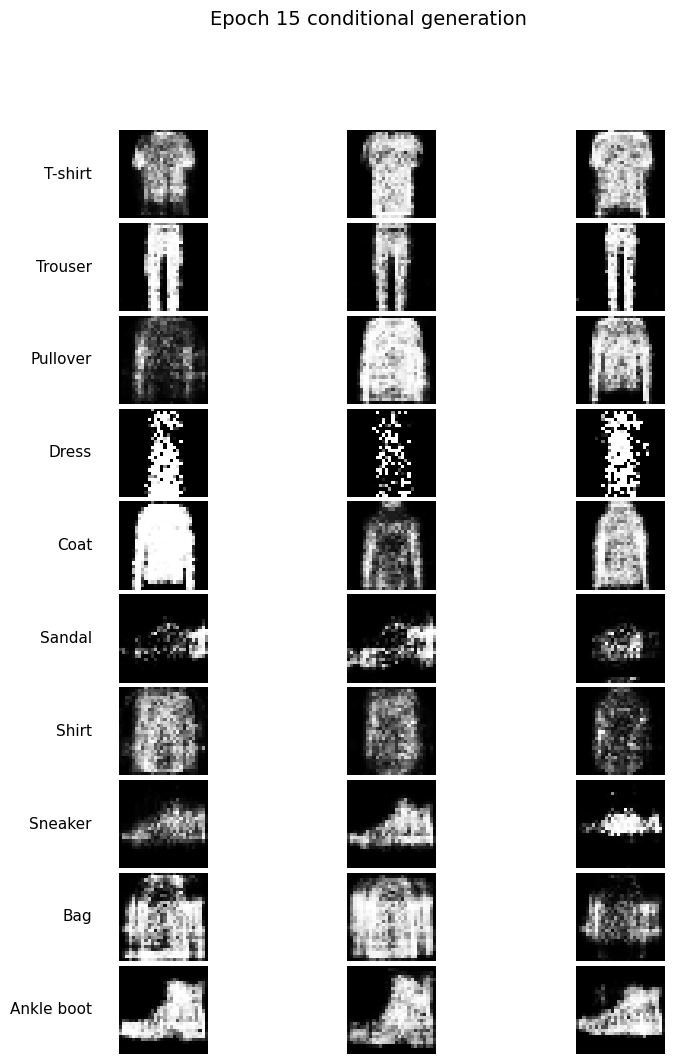

[Epoch 16/30] [Batch 100/938] [C loss: -0.3970] [G loss: -0.8863]
[Epoch 16/30] [Batch 200/938] [C loss: -0.6961] [G loss: -0.3414]
[Epoch 16/30] [Batch 300/938] [C loss: -0.7073] [G loss: 1.9668]
[Epoch 16/30] [Batch 400/938] [C loss: 0.6219] [G loss: -1.5634]
[Epoch 16/30] [Batch 500/938] [C loss: -0.8383] [G loss: -3.0544]
[Epoch 16/30] [Batch 600/938] [C loss: -0.7687] [G loss: 2.0267]
[Epoch 16/30] [Batch 700/938] [C loss: -0.1245] [G loss: -1.1971]
[Epoch 16/30] [Batch 800/938] [C loss: -1.0609] [G loss: 2.1007]
[Epoch 16/30] [Batch 900/938] [C loss: -0.3209] [G loss: -1.9281]
[Epoch 17/30] [Batch 100/938] [C loss: -0.6610] [G loss: -0.4679]
[Epoch 17/30] [Batch 200/938] [C loss: -0.3023] [G loss: -1.2762]
[Epoch 17/30] [Batch 300/938] [C loss: -1.0050] [G loss: 0.3905]
[Epoch 17/30] [Batch 400/938] [C loss: -0.5172] [G loss: -3.2723]
[Epoch 17/30] [Batch 500/938] [C loss: -0.7172] [G loss: 0.1759]
[Epoch 17/30] [Batch 600/938] [C loss: -1.2449] [G loss: -1.0100]
[Epoch 17/30] [B

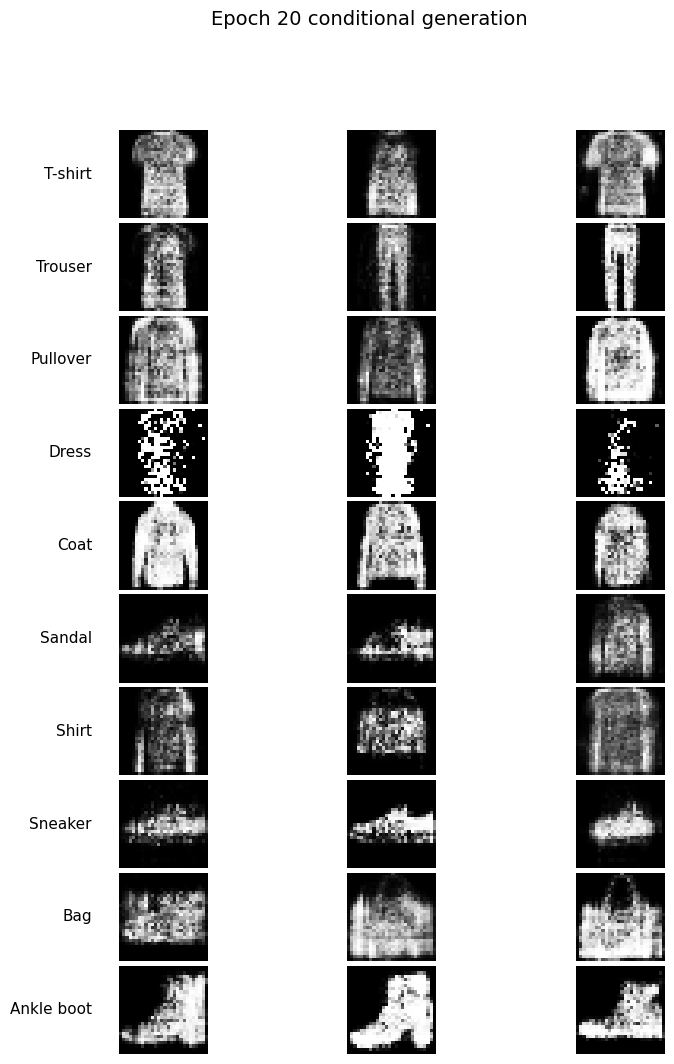

[Epoch 21/30] [Batch 100/938] [C loss: 0.2389] [G loss: -0.4554]
[Epoch 21/30] [Batch 200/938] [C loss: -0.4927] [G loss: 0.7567]
[Epoch 21/30] [Batch 300/938] [C loss: -0.0630] [G loss: -0.2027]
[Epoch 21/30] [Batch 400/938] [C loss: 0.3383] [G loss: -1.2118]
[Epoch 21/30] [Batch 500/938] [C loss: -0.4674] [G loss: -0.1358]
[Epoch 21/30] [Batch 600/938] [C loss: -0.3843] [G loss: -0.7044]
[Epoch 21/30] [Batch 700/938] [C loss: -0.2739] [G loss: -1.0316]
[Epoch 21/30] [Batch 800/938] [C loss: -0.4338] [G loss: -0.2357]
[Epoch 21/30] [Batch 900/938] [C loss: -0.8181] [G loss: -3.2441]
[Epoch 22/30] [Batch 100/938] [C loss: 0.0591] [G loss: -1.3170]
[Epoch 22/30] [Batch 200/938] [C loss: -0.5742] [G loss: -0.2491]
[Epoch 22/30] [Batch 300/938] [C loss: -0.2868] [G loss: -0.6673]
[Epoch 22/30] [Batch 400/938] [C loss: -0.5085] [G loss: -1.4129]
[Epoch 22/30] [Batch 500/938] [C loss: 0.0360] [G loss: -0.8388]
[Epoch 22/30] [Batch 600/938] [C loss: -0.4781] [G loss: -1.0177]
[Epoch 22/30] [

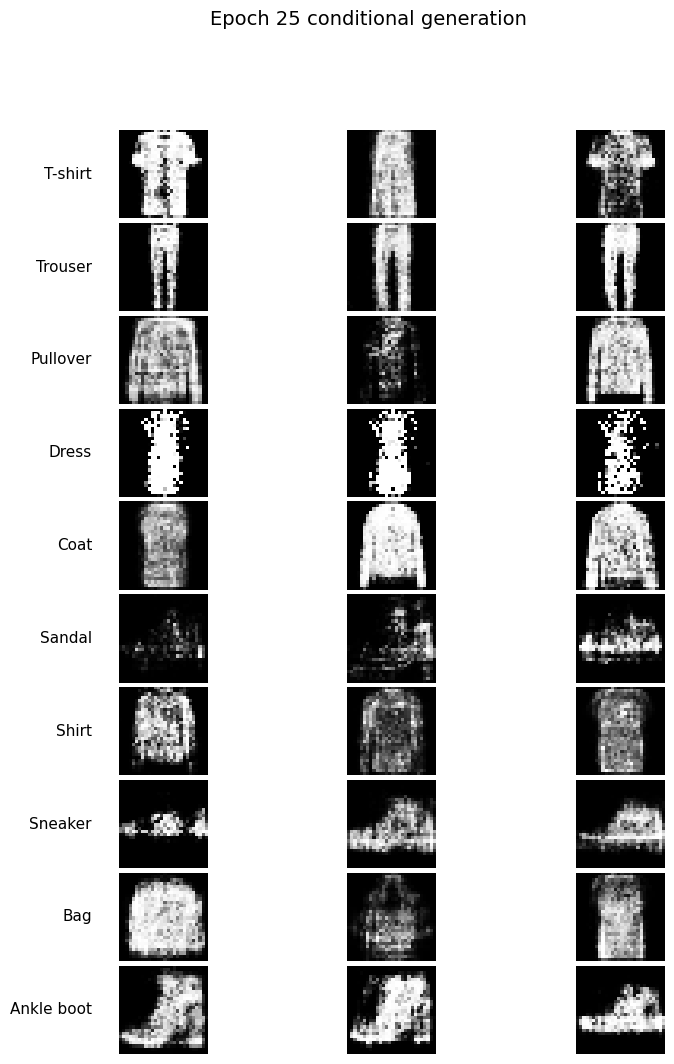

[Epoch 26/30] [Batch 100/938] [C loss: 0.0385] [G loss: -1.7018]
[Epoch 26/30] [Batch 200/938] [C loss: -0.6539] [G loss: -2.7540]
[Epoch 26/30] [Batch 300/938] [C loss: -0.4678] [G loss: -1.3062]
[Epoch 26/30] [Batch 400/938] [C loss: -0.4819] [G loss: 0.8637]
[Epoch 26/30] [Batch 500/938] [C loss: 0.2337] [G loss: -3.5413]
[Epoch 26/30] [Batch 600/938] [C loss: -0.5925] [G loss: -0.3344]
[Epoch 26/30] [Batch 700/938] [C loss: -0.2501] [G loss: -1.1452]
[Epoch 26/30] [Batch 800/938] [C loss: -0.2857] [G loss: -1.0537]
[Epoch 26/30] [Batch 900/938] [C loss: -0.1205] [G loss: -0.0552]
[Epoch 27/30] [Batch 100/938] [C loss: -0.1267] [G loss: -0.7296]
[Epoch 27/30] [Batch 200/938] [C loss: -0.3221] [G loss: -1.6411]
[Epoch 27/30] [Batch 300/938] [C loss: -0.4511] [G loss: 0.4866]
[Epoch 27/30] [Batch 400/938] [C loss: -0.0114] [G loss: 0.5429]
[Epoch 27/30] [Batch 500/938] [C loss: -0.4162] [G loss: -1.9074]
[Epoch 27/30] [Batch 600/938] [C loss: 0.7319] [G loss: -0.6638]
[Epoch 27/30] [B

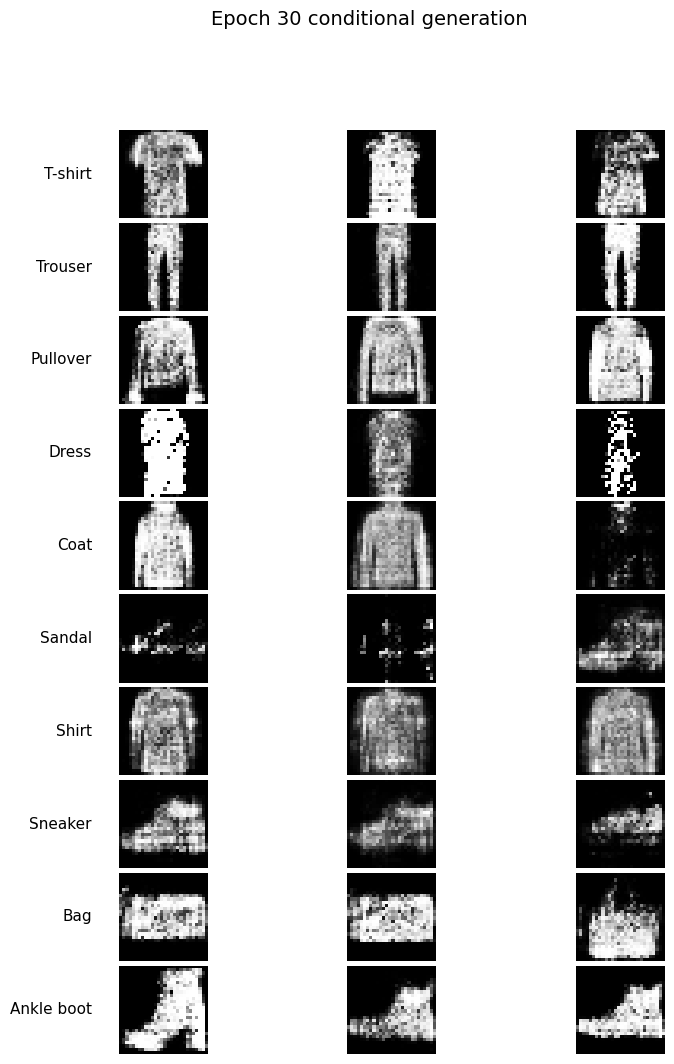

In [136]:
G_losses_dropout, C_losses_dropout = train_conditional_wgan(generator_dropout, critic_dropout, dataloader, config)

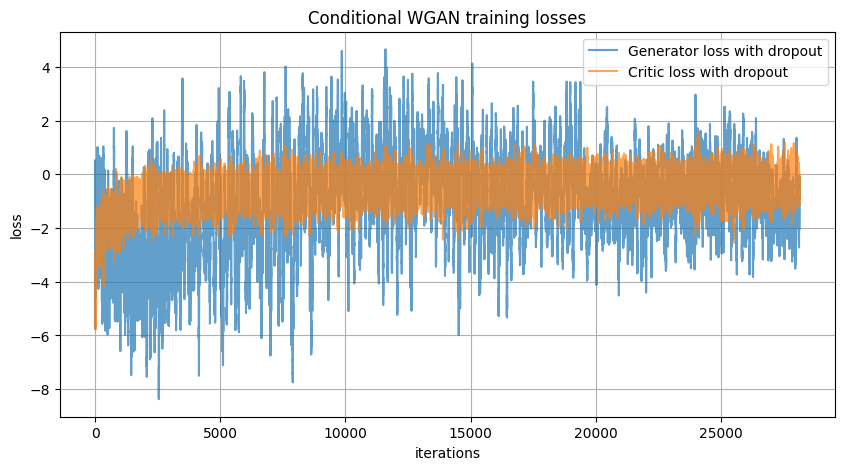

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses_dropout, label='Generator loss with dropout', alpha=0.7)
plt.plot(C_losses_dropout, label='Critic loss with dropout', alpha=0.7)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Conditional WGAN training losses')
plt.legend()
plt.grid(True)
plt.show()

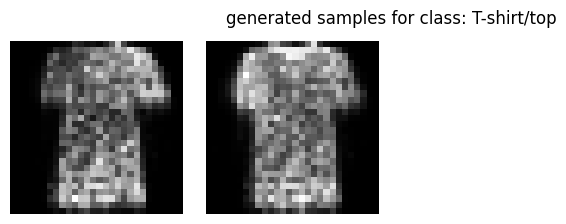

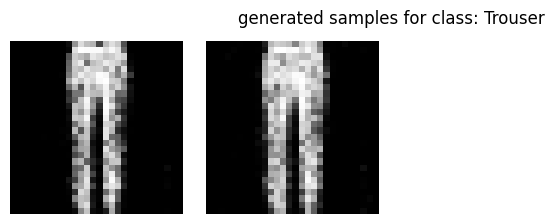

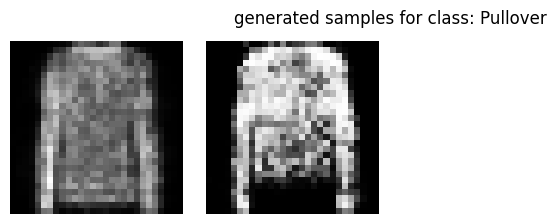

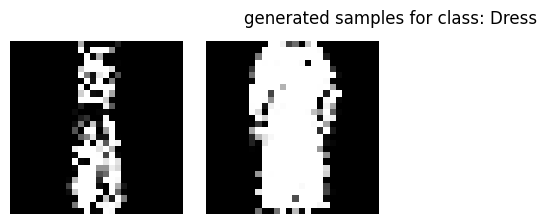

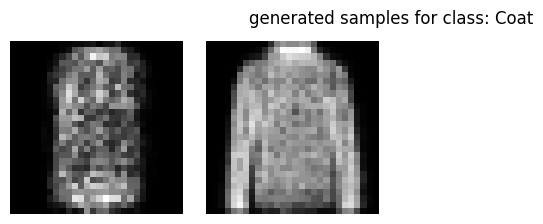

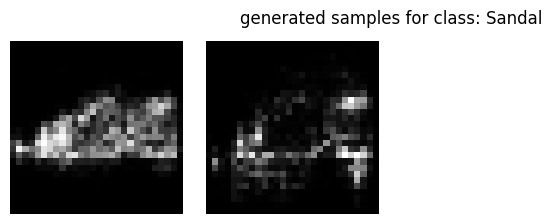

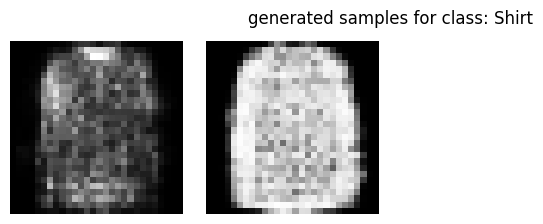

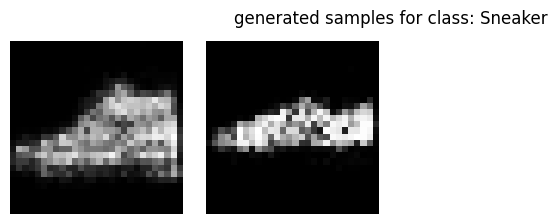

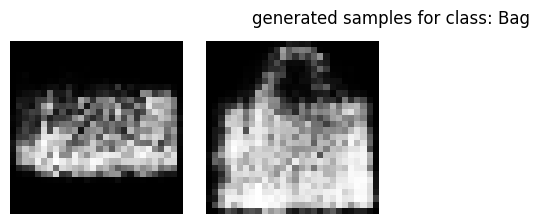

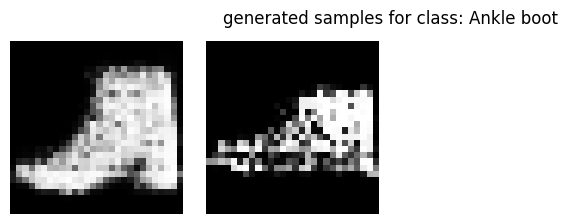

In [139]:
for k in range(10):
    generate_class_samples(generator_dropout, k)

#### Выводы по Dropout:
Качество генерации ухудшилось, да и график лосса дискриминатора стал принимать положительные числа, хотя стремимся к минимуму. В сравнении, без Dropout принимаются отрицательные числа, и качество генерации лучше. Возможно это связано с использованием спектральной нормализации.

Также заметил, что для условного GAN grad penalty делает лосс генератора слишком маленьким, где-то от -30 до -50. Для условного GAN лучше зашла спектральная нормализация. А вот для обычной генерации лучше зашёл grad penalty.